In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import copy

import math
import torch
from torch.nn.modules.transformer import TransformerEncoder, TransformerEncoderLayer
from torch.nn.modules import LayerNorm, Linear, ReLU
import torch.nn as nn
import torch.nn.functional as F
import sklearn.metrics
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pickle
from torch.utils.data import DataLoader

import csv
import os
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import torch
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors


device = 'cuda' if torch.cuda.is_available() else 'cpu'


# Inputs

In [ ]:
#shape (Num, Channels, Timesteps)
Input_path = '/kaggle/input/active-learning-subset/tar_image_subset.npy' 
#shape (Num)
Labels_path = '/kaggle/input/active-learning-subset/label_target_subset.npy'

"""
----------------------------------------------------------------------------------------
Loss Function selection
Currently available:
"ce = cross entropy loss","ls = LabelSmoothingCrossEntropyLoss"
"""
loss_mode = "ls"

"""
---------------------------------------------------------------------------------------------
Active Learning Method(s) to use
Currently available:
"random", "entropy", "margin", "least_confident", "diversity", "entropy_diversity", "density"
"""
strategies = [ 'margin', 'least_confident']

"""
----------------------------------------------------------------------------------------
Shape(s) of data to test on:
(Initial samples, Iterations of AL loop, Query Sample Size)
"""
data = [(100,20,10), (300,20,10)]


test_size = 0.2
lr = 1e-1
weight_decay = 1e-4
label_smoothing = 0.1
ignore_index = -100

In [22]:
#prints how many labeled samples used, and how many samples will hte model effectively be trained on
def eff_total_labeled_samples(init, iterations, query):
    return round(iterations * init + query * (iterations * (iterations - 1)) // 2)

def total_labeled_samples(init, iterations, query):
    return init+query*iterations

print("Samples used: ",[total_labeled_samples(a, b, c) for a, b, c in data])
print("Effective Samples trained on: ",[eff_total_labeled_samples(a, b, c) for a, b, c in data])

Samples used:  [300, 500]
Effective Samples trained on:  [3900, 7900]


In [3]:
#check if strategy name is correct
for strategy in strategies:
    strategy = strategy.strip().lower()
    allowed_strategies = [
        "entropy", "least_confident", "margin", "random",
        "diversity", "density", "entropy_diversity"
    ]
    
    if strategy not in allowed_strategies:
        raise ValueError(f"[ERROR] Unknown strategy '{strategy}'. Must be one of: {allowed_strategies}")

# Data Loader

In [4]:
X = np.load(Input_path) 
y = np.load(Labels_path)

X_pool, X_val, y_pool, y_val = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val  shape: {y_val.shape}")


X shape: (20000, 6, 28)
y shape: (20000,)
X_val shape: (4000, 6, 28)
y_val  shape: (4000,)


In [5]:
y_sample = y
X_sample = X

# Checking Label distribution
label_counts = Counter(y_sample)
df_labels = pd.DataFrame.from_dict(label_counts, orient='index').sort_index()
df_labels.columns = ['count']
df_labels['percent'] = 100 * df_labels['count'] / len(y_sample)
print("\nLabel distribution:")
print(df_labels)

# Checking normalisation
channel_variance = np.var(X_sample, axis=2).mean(axis=0)
channel_mean = X_sample.mean(axis=(0, 2))
channel_std = X_sample.std(axis=(0, 2))
df_stats = pd.DataFrame({
    'channel': range(6),
    'mean': channel_mean,
    'std_dev': channel_std,
    'variance': channel_variance
})
print("\nMean, Std Dev and Variance per Channel:")
print(df_stats)


Label distribution:
   count  percent
0   9081   45.405
1   2603   13.015
2   8316   41.580

Mean, Std Dev and Variance per Channel:
   channel      mean   std_dev  variance
0        0  0.004546  0.999189  0.730689
1        1  0.004955  0.999538  0.721030
2        2  0.003958  1.000457  0.755685
3        3  0.001807  1.000751  0.783507
4        4  0.001153  1.000271  0.634434
5        5  0.001723  1.000909  0.731176


In [6]:
# Total number of samples
total_samples = sum(label_counts.values())

# Number of classes
num_classes = max(label_counts.keys()) + 1  # assuming labels are integers from 0-n

# Computing weights for each class as inverse frequency
class_weights = []
for i in range(num_classes):
    count = label_counts.get(i, 0)
    if count == 0:
        class_weights.append(1e-6)  # ignoring non-present classes
    else:
        class_weights.append(total_samples / (num_classes * count))

print(class_weights)
# Convert to torch tensor for CE loss function
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)


[0.7341335388907242, 2.5611473940325267, 0.801667468334135]


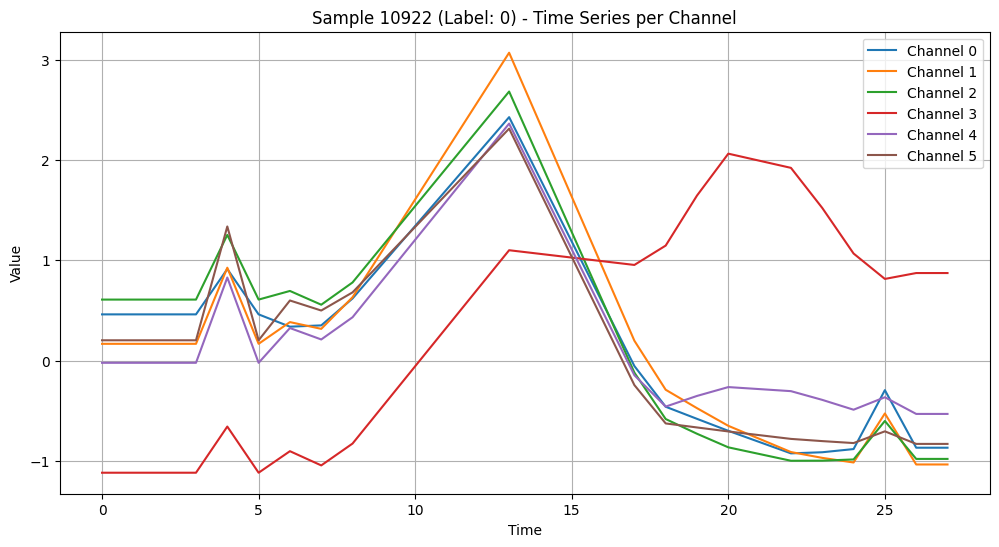

In [7]:
#viewing sample X image channel values per timestep

i = np.random.randint(0, len(X))
sample = X[i]  # Shape: (6, T)

plt.figure(figsize=(12, 6))
for c in range(6):
    plt.plot(sample[c], label=f'Channel {c}')
plt.title(f"Sample {i} (Label: {y[i]}) - Time Series per Channel")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

# Dataloader

In [8]:
class Dataset():
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __getitem__(self, index):
        return {
            "x": self.X[index],  # shape: [C, T]
            "y": self.y[index]
        }

    def __len__(self):
        return len(self.X)

# Loss Functions

In [9]:

class Loss:
    def __init__(self, weight=None, ignore_index=-100, device=None, smoothing=0.1):
        self.weight = weight
        self.ignore_index = ignore_index
        self.device = device
        self.smoothing = smoothing
        self.criterion = None
        self.loss_func = None

    def build(self, mode='ce'):
        """
        Available modes: 'ce', 'ls'
        """
        if mode == 'ce':
            self.criterion = nn.CrossEntropyLoss(weight=self.weight, ignore_index=self.ignore_index)
            self.loss_func = self.cross_entropy_loss

        elif mode == 'ls':
            self.loss_func = self.label_smoothing_loss

        else:
            raise NotImplementedError(f"Loss mode '{mode}' is not implemented.")

        if self.device is not None and self.criterion is not None:
            self.criterion = self.criterion.to(self.device)

        return self.loss_func

    def cross_entropy_loss(self, logits, targets):
        return self.criterion(logits, targets)

    def label_smoothing_loss(self, logits, targets):
        log_probs = F.log_softmax(logits, dim=-1)
        
        valid = targets != self.ignore_index
        log_probs = log_probs[valid]
        targets = targets[valid]
        
        nll_loss = -log_probs.gather(dim=-1, index=targets.unsqueeze(1)).squeeze(1)
        smooth_loss = -log_probs.mean(dim=-1)
        loss = (1.0 - self.smoothing) * nll_loss + self.smoothing * smooth_loss
    
        if self.weight is not None:
            weight = self.weight.to(logits.device)
            loss = loss * weight[targets]
    
        return loss.mean()


# Model

In [10]:
################ CNN Backbone 
def conv_block(in_channels: int, out_channels: int, dropout=0.3) -> nn.Module:
    return nn.Sequential(
        nn.Conv1d(in_channels, out_channels, 5, padding='same'),
        nn.BatchNorm1d(out_channels),
        nn.ReLU(),
        nn.Dropout(dropout),
    )

class cnn(nn.Module):
    def __init__(self):
        super(cnn, self).__init__()
        self.conv1 = conv_block(6, 64)
        self.conv2 = conv_block(64, 128)
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 512)
        self.conv5 = conv_block(512, 1024)
        self.global_pool = nn.AdaptiveAvgPool1d(1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        return x

 
################ Fully connected network
class FC(nn.Module):
    def __init__(self, input_dim):
        super(FC, self).__init__()
        self.dropout = nn.Dropout(0.5)
        self.fco = nn.Linear(input_dim, 3)

    def forward(self, x):
        x = self.dropout(x)
        x = self.fco(x)
        return x



class FullModel(nn.Module):
    def __init__(self, backbone, fc):
        super().__init__()
        self.backbone = backbone
        self.fc = fc

    def forward(self, x):
        feat = self.backbone(x)
        out = self.fc(feat)
        return feat, out

In [11]:
#pretrained weights
map_location=torch.device(device)

backbone = cnn()
fc = FC(1024)

#loading backbone weights
state_dict = torch.load('/kaggle/input/active-learning-subset/backboneSiteA2019.pth', map_location=map_location)
# Remove "module." prefix
new_state_dict = {}
for k, v in state_dict.items():
    new_key = k.replace("module.", "")  # remove module. prefix
    new_state_dict[new_key] = v

backbone.load_state_dict(new_state_dict)

#loading fc weights
state_dict = torch.load('/kaggle/input/active-learning-subset/fcSiteA2019.pth', map_location=map_location)
# Remove "module." prefix
new_state_dict = {}
for k, v in state_dict.items():
    new_key = k.replace("module.", "")  # remove module. prefix
    new_state_dict[new_key] = v

fc.load_state_dict(new_state_dict)

model = FullModel(backbone, fc).to(device)
initial_state_dict = copy.deepcopy(model.state_dict())

# Active Learning methods

In [12]:
def query_samples(model, dataset, query_size, strategy, device, already_selected_idx=None):
    model.eval()

    #check if strategy is correct
    strategy = strategy.strip().lower()
    allowed_strategies = [
        "entropy", "least_confident", "margin", "random",
        "diversity", "density", "entropy_diversity"
    ]
    
    if strategy not in allowed_strategies:
        raise ValueError(f"[ERROR] Unknown strategy '{strategy}'. Must be one of: {allowed_strategies}")

    
    dataloader = DataLoader(dataset, batch_size=128)
    all_scores = []
    all_features = []
    if already_selected_idx is None:
        already_selected_idx = []

    with torch.no_grad():
        for batch in dataloader:
            x = batch["x"].to(device)
            features, out = model(x)
            probs = F.softmax(out, dim=1)

            if strategy in ["entropy", "least_confident", "margin", "random", "entropy_diversity"]:
                score = None
                if strategy in ["entropy", "entropy_diversity"]:
                    score = -torch.sum(probs * torch.log(probs + 1e-10), dim=1)
                elif strategy == "least_confident":
                    score = 1 - probs.max(dim=1)[0]
                elif strategy == "margin":
                    sorted_probs, _ = probs.sort(dim=1, descending=True)
                    score = -(sorted_probs[:, 0] - sorted_probs[:, 1])
                elif strategy == "random":
                    score = torch.rand(len(x), device=device)

                all_scores.extend(score.cpu().numpy())

            if strategy in ["diversity", "density", "entropy_diversity"]:
                all_features.append(features.cpu().numpy())

    if strategy in ["entropy", "least_confident", "margin", "random"]:
        indices = np.argsort(all_scores)[-query_size:]
        return indices

    all_features = np.concatenate(all_features, axis=0)

    if strategy == "diversity":
        # Core-set (k-Center Greedy)
        if already_selected_idx is None or len(already_selected_idx) == 0:
            selected = [np.random.randint(len(all_features))]
        else:
            selected = already_selected_idx.copy()

        selected_features = all_features[selected]
        remaining = list(set(range(len(all_features))) - set(selected))

        for _ in range(query_size):
            dists = pairwise_distances(all_features[remaining], selected_features, metric="euclidean")
            min_dists = np.min(dists, axis=1)
            next_idx = remaining[np.argmax(min_dists)]
            selected.append(next_idx)
            selected_features = np.vstack([selected_features, all_features[next_idx].reshape(1, -1)])
            remaining.remove(next_idx)

        new_indices = list(set(selected) - set(already_selected_idx))[-query_size:]
        return np.array(new_indices)

    elif strategy == "density":
        if all_features.shape[1] > 64:
            from sklearn.decomposition import PCA
            pca = PCA(n_components=64)
            all_features = pca.fit_transform(all_features)

        all_features = all_features.astype(np.float32)
        nbrs = NearestNeighbors(n_neighbors=6, algorithm='auto', metric='euclidean').fit(all_features)
        distances, _ = nbrs.kneighbors(all_features)
        avg_neighbor_dist = distances[:, 1:].mean(axis=1)
        density_scores = -avg_neighbor_dist
        indices = np.argsort(density_scores)[-query_size:]
        return indices

    elif strategy == "entropy_diversity":
        # Hybrid: Select top-2×query_size most uncertain samples, then apply core-set
        all_scores = np.array(all_scores)
        all_features = np.array(all_features)

        top_uncertain_idx = np.argsort(all_scores)[-2 * query_size:]
        uncertain_features = all_features[top_uncertain_idx]

        # Core-set on uncertain samples
        selected = [np.random.randint(len(uncertain_features))]
        selected_features = uncertain_features[selected]
        remaining = list(set(range(len(uncertain_features))) - set(selected))

        for _ in range(query_size - 1):
            dists = pairwise_distances(uncertain_features[remaining], selected_features, metric="euclidean")
            min_dists = np.min(dists, axis=1)
            next_idx = remaining[np.argmax(min_dists)]
            selected.append(next_idx)
            selected_features = np.vstack([selected_features, uncertain_features[next_idx].reshape(1, -1)])
            remaining.remove(next_idx)

        final_indices = top_uncertain_idx[selected]
        return np.array(final_indices)


# Train/eval loop

In [13]:
def train_one_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()
    total_loss, all_preds, all_targets = 0, [], []
    
    for batch in dataloader:
        x, y = batch["x"].to(device), batch["y"].to(device)

        optimizer.zero_grad()
        _, out = model(x)
        loss = loss_fn(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * len(x)
        preds = torch.argmax(out, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(y.cpu().numpy())

    avg_loss = total_loss / len(dataloader.dataset)
    acc = np.mean(np.array(all_preds) == np.array(all_targets))
    f1s = sklearn.metrics.f1_score(all_targets, all_preds, average=None)
    return avg_loss, acc, f1s, np.mean(f1s)



def _eval_perf(model, dataloader, device, loss_fn=None):
    model.eval()
    pred, gt = [], []
    total_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            x, y = batch["x"].to(device), batch["y"].to(device)
            _, outputs = model(x)
            preds = torch.argmax(outputs, dim=1)
            if loss_fn:
                total_loss += loss_fn(outputs, y).item() * len(x)

            pred.extend(preds.cpu().numpy())
            gt.extend(y.cpu().numpy())

    acc = np.mean(np.array(pred) == np.array(gt))
    f1s = sklearn.metrics.f1_score(gt, pred, average=None)
    avg_f1 = np.mean(f1s)

    if loss_fn:
        avg_loss = total_loss / len(dataloader.dataset)
        return avg_loss, f1s, acc, avg_f1
    else:
        return 0, f1s, acc, avg_f1


In [14]:
def plot_round_metrics(history):
    round_id = len(history["epoch_metrics"]) - 1
    epoch_stats = history["epoch_metrics"][round_id]
    epochs = list(range(1, len(epoch_stats) + 1))

    train_loss = [e["train_loss"] for e in epoch_stats]
    val_loss = [e["val_loss"] for e in epoch_stats]
    train_acc = [e["train_acc"] for e in epoch_stats]
    train_f1 = [e["train_avg_f1"] for e in epoch_stats]
    val_acc = [e["val_acc"] for e in epoch_stats]
    val_f1 = [e["val_avg_f1"] for e in epoch_stats]

    plt.figure(figsize=(15, 4))

    # Loss plot
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_loss, label="Train Loss")
    plt.plot(epochs, val_loss, label="Val Loss")
    plt.title(f"[Round {round_id+1}] Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_acc, label="Train Acc")
    plt.plot(epochs, val_acc, label="Val Acc")
    plt.title(f"[Round {round_id+1}] Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Avg F1 plot
    plt.subplot(1, 3, 3)
    plt.plot(epochs, train_f1, label="Train F1")
    plt.plot(epochs, val_f1, label="Val F1")
    plt.title(f"[Round {round_id+1}] Avg F1")
    plt.xlabel("Epoch")
    plt.ylabel("Avg F1")
    plt.legend()

    plt.tight_layout()
    plt.show()



def plot_final_performance(history):
    samples = history["samples"]
    val_acc = history["round_val_acc"]
    val_f1 = history["round_val_avg_f1"]

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(samples, val_acc, marker='o')
    plt.title("Val Accuracy vs Labeled Samples")
    plt.xlabel("Labeled Samples")
    plt.ylabel("Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(samples, val_f1, marker='o')
    plt.title("Val Avg F1 vs Labeled Samples")
    plt.xlabel("Labeled Samples")
    plt.ylabel("Avg F1")

    plt.tight_layout()
    plt.show()


# Active Learning Loop

In [15]:
def active_learning_loop(model, labeled_dataset, unlabeled_dataset, val_dataset, strategy, device, iters=10, query_size=100, final_epochs=5, loss_mode = 'ce'):
    
    loss_handler = Loss(weight=class_weights, ignore_index=ignore_index, device=device, smoothing= label_smoothing)
    loss_fn = loss_handler.build(mode=loss_mode) 
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    history = {
        "strategy": strategy,
        "samples": [],
        "epoch_metrics": [],
        "round_val_acc": [],
        "round_val_avg_f1": []
    }

    for it in range(iters):
        print(f"\n[AL Round {it+1}/{iters}] — Labeled samples: {len(labeled_dataset)}")

        train_loader = DataLoader(labeled_dataset, batch_size=64, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=64)

        epoch_stats = []

        if it <= 3:
            epochs = 5
        elif 4 <= it <= 10:
            epochs = 10
        elif 11 <= it:
            epochs = final_epochs
        else:
            epochs = final_epochs
        
        for ep in tqdm(range(epochs), desc="Epoch", leave=False):
            tr_loss, tr_acc, tr_f1s, tr_avgf1 = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
            val_loss, val_f1s, val_acc, val_avgf1 = _eval_perf(model, val_loader, device, loss_fn)

            epoch_stats.append({
                "train_loss": tr_loss,
                "train_acc": tr_acc,
                "train_avg_f1": tr_avgf1,
                "val_loss": val_loss,
                "val_acc": val_acc,
                "val_avg_f1": val_avgf1
            })

        history["samples"].append(len(labeled_dataset))
        history["epoch_metrics"].append(epoch_stats)
        history["round_val_acc"].append(val_acc)
        history["round_val_avg_f1"].append(val_avgf1)

        # Query next samples
        if len(unlabeled_dataset) < query_size:
            print("Unlabeled pool exhausted.")
            break

        selected_idxs = query_samples(model, unlabeled_dataset, query_size, strategy, device)

        new_x = [unlabeled_dataset.X[i] for i in selected_idxs]
        new_y = [unlabeled_dataset.y[i] for i in selected_idxs]

        labeled_dataset.X = torch.cat([labeled_dataset.X, torch.stack(new_x)], dim=0)
        labeled_dataset.y = torch.cat([labeled_dataset.y, torch.tensor(new_y)], dim=0)

        keep_idxs = list(set(range(len(unlabeled_dataset))) - set(selected_idxs))
        unlabeled_dataset.X = torch.stack([unlabeled_dataset.X[i] for i in keep_idxs])
        unlabeled_dataset.y = torch.tensor([unlabeled_dataset.y[i] for i in keep_idxs])

        print(f"\nEpoch {epochs}/{epochs}")
        print(f"Train — Loss: {tr_loss:.4f} | Acc: {tr_acc:.4f} | Avg F1: {tr_avgf1:.4f}")
        print(f"Val   — Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | Avg F1: {val_avgf1:.4f}")

        
        plot_round_metrics(history)

    plot_final_performance(history)
    return history


X_labeled shape: (100, 6, 28)
y_labeled shape: (100,)
X_unlabeled shape: (15900, 6, 28)
y_unlabeled shape: (15900,)

=== Running strategy: MARGIN ===

[AL Round 1/20] — Labeled samples: 100



Epoch 5/5
Train — Loss: 2.1998 | Acc: 0.3200 | Avg F1: 0.2828
Val   — Loss: 1954.8122 | Acc: 0.4495 | Avg F1: 0.2146


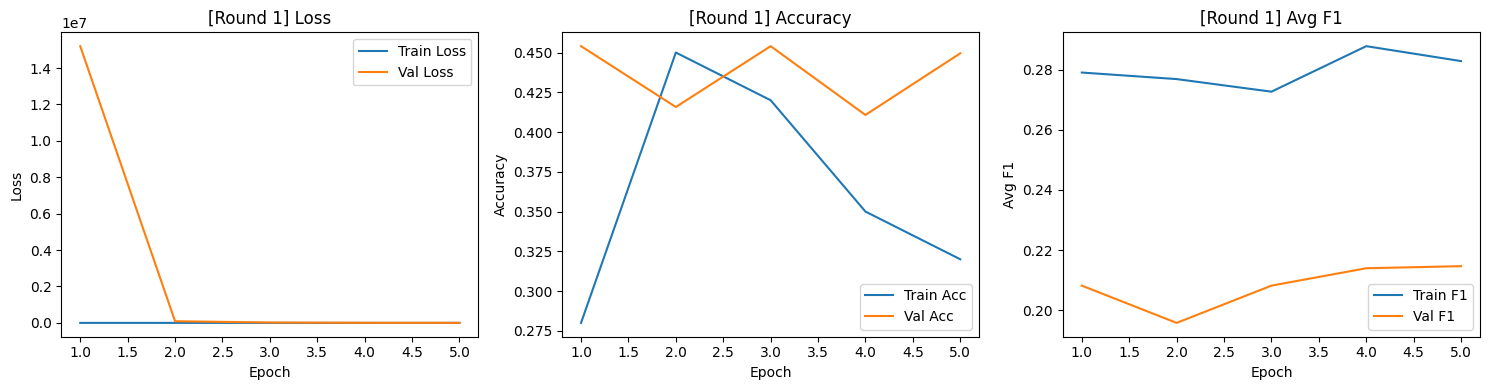


[AL Round 2/20] — Labeled samples: 110



Epoch 5/5
Train — Loss: 1.3590 | Acc: 0.2727 | Avg F1: 0.2699
Val   — Loss: 50.0411 | Acc: 0.4235 | Avg F1: 0.2663


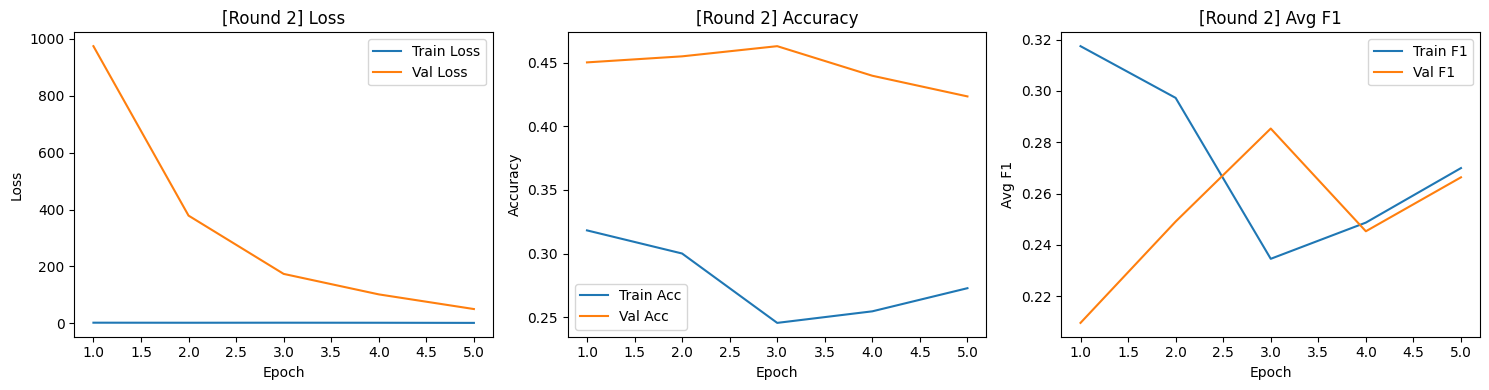


[AL Round 3/20] — Labeled samples: 120



Epoch 5/5
Train — Loss: 1.2063 | Acc: 0.2500 | Avg F1: 0.2460
Val   — Loss: 2.6700 | Acc: 0.3375 | Avg F1: 0.3220


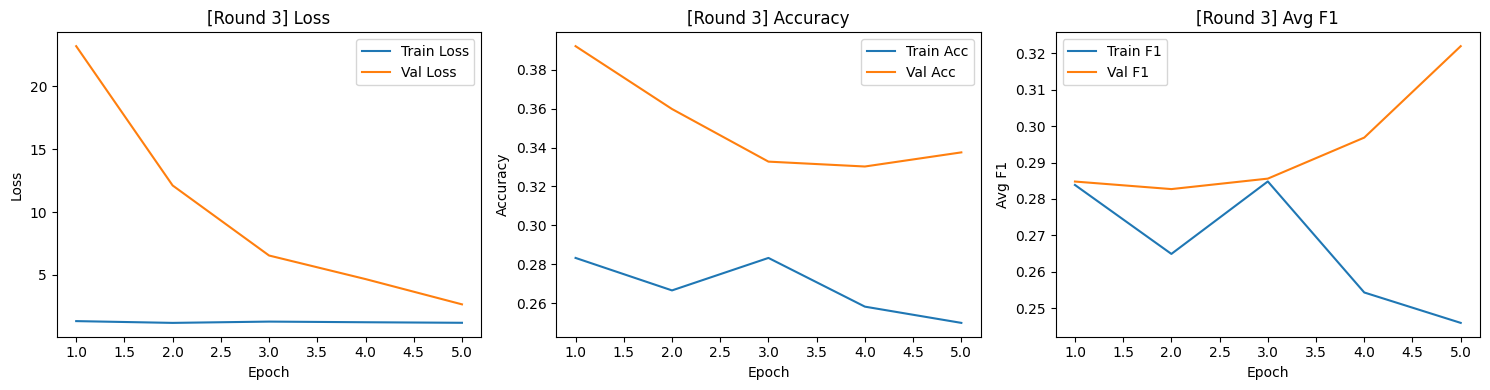


[AL Round 4/20] — Labeled samples: 130



Epoch 5/5
Train — Loss: 1.2825 | Acc: 0.4231 | Avg F1: 0.2565
Val   — Loss: 1.1579 | Acc: 0.4348 | Avg F1: 0.2912


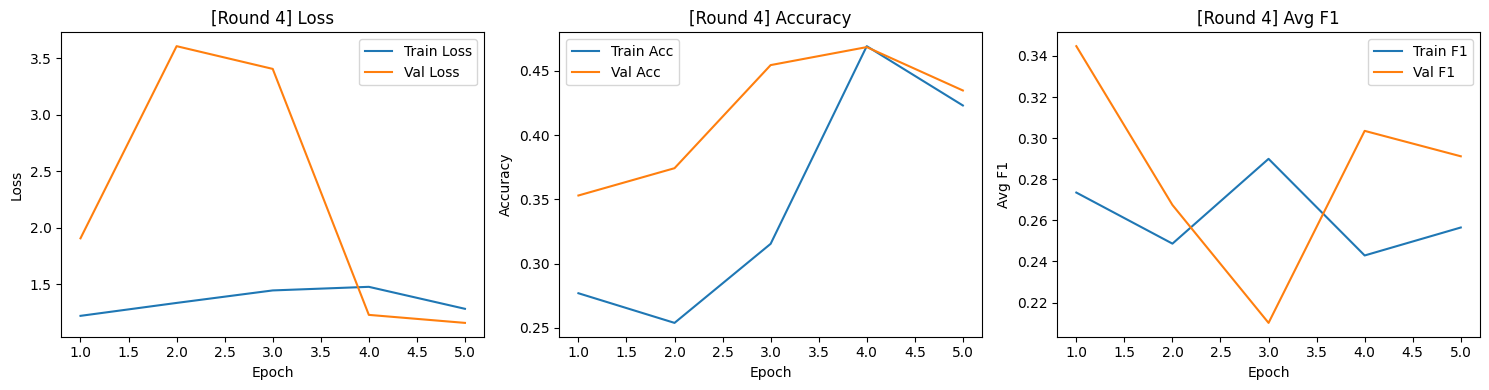


[AL Round 5/20] — Labeled samples: 140



Epoch 10/10
Train — Loss: 1.1386 | Acc: 0.3071 | Avg F1: 0.3054
Val   — Loss: 1.6517 | Acc: 0.2945 | Avg F1: 0.2425


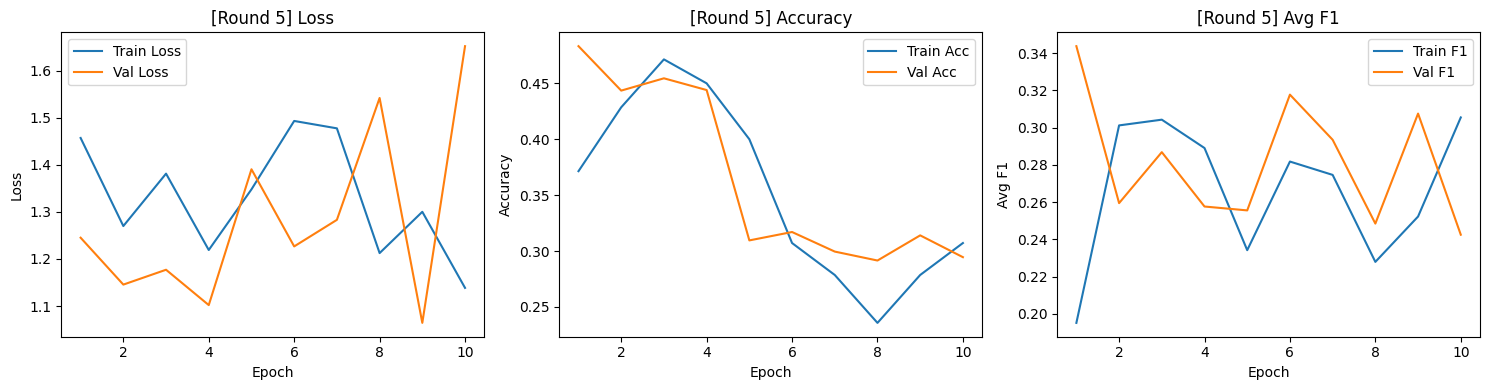


[AL Round 6/20] — Labeled samples: 150



Epoch 10/10
Train — Loss: 1.0468 | Acc: 0.3000 | Avg F1: 0.3041
Val   — Loss: 1.1288 | Acc: 0.3352 | Avg F1: 0.3279


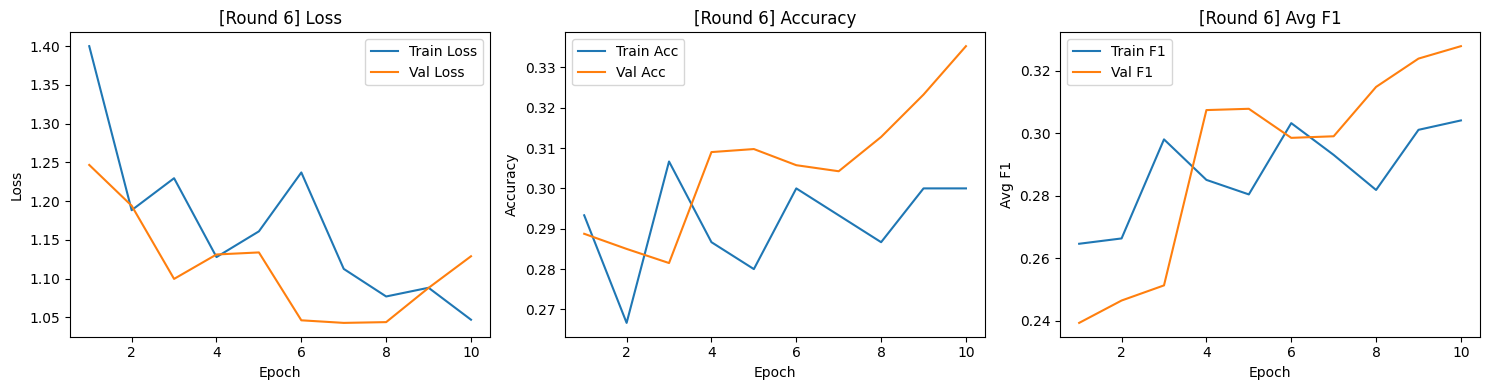


[AL Round 7/20] — Labeled samples: 160



Epoch 10/10
Train — Loss: 0.9969 | Acc: 0.3625 | Avg F1: 0.3623
Val   — Loss: 0.9794 | Acc: 0.4098 | Avg F1: 0.3907


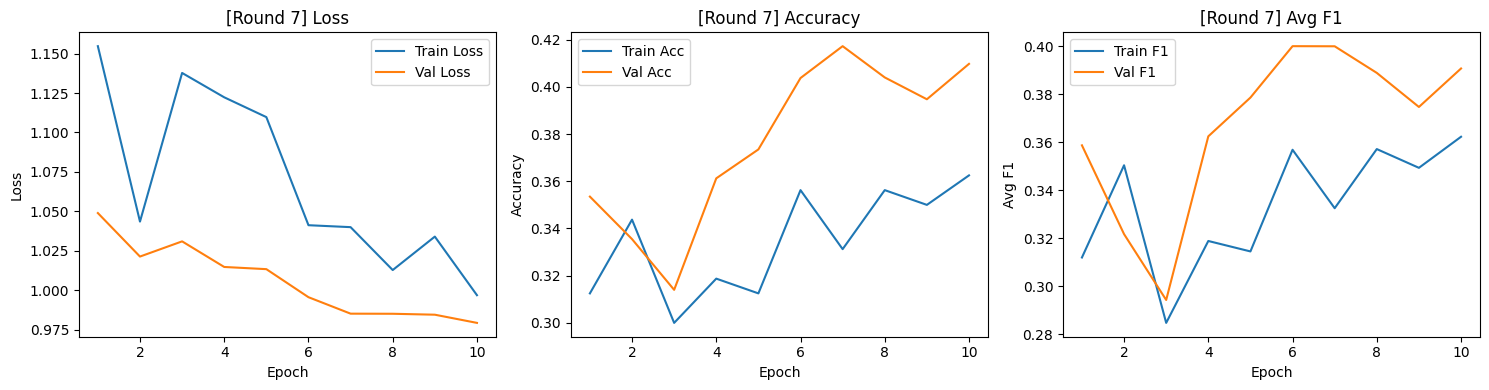


[AL Round 8/20] — Labeled samples: 170



Epoch 10/10
Train — Loss: 0.9443 | Acc: 0.4941 | Avg F1: 0.4823
Val   — Loss: 0.9328 | Acc: 0.4985 | Avg F1: 0.4853


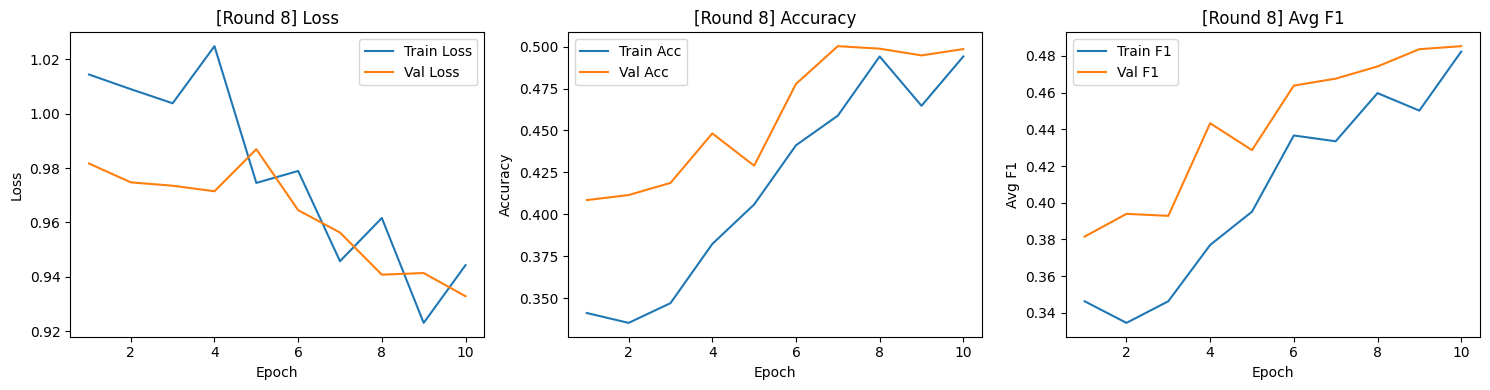


[AL Round 9/20] — Labeled samples: 180



Epoch 10/10
Train — Loss: 0.8598 | Acc: 0.4778 | Avg F1: 0.4416
Val   — Loss: 0.9084 | Acc: 0.5162 | Avg F1: 0.5034


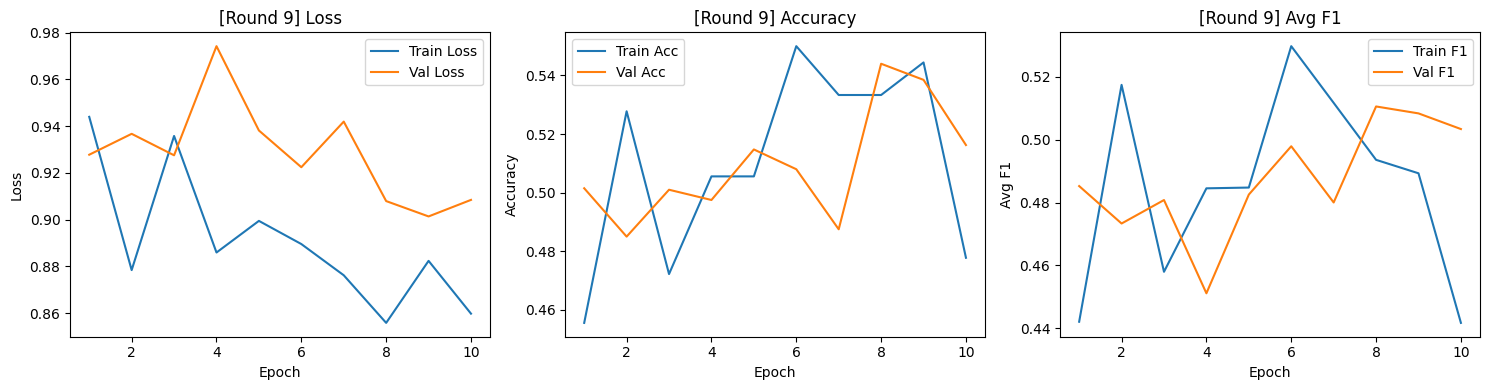


[AL Round 10/20] — Labeled samples: 190



Epoch 10/10
Train — Loss: 0.8797 | Acc: 0.6316 | Avg F1: 0.5886
Val   — Loss: 0.8640 | Acc: 0.5863 | Avg F1: 0.5565


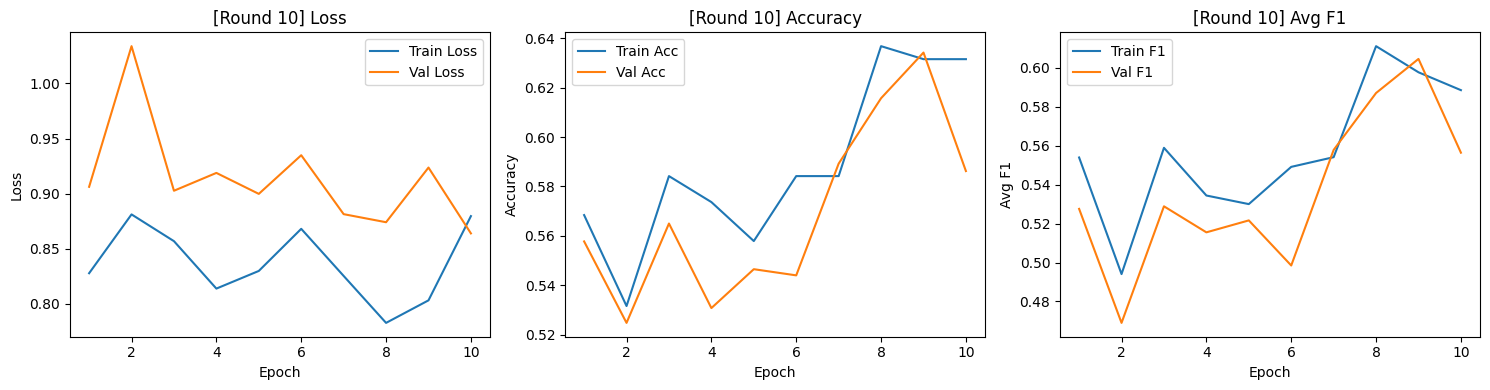


[AL Round 11/20] — Labeled samples: 200



Epoch 10/10
Train — Loss: 0.9041 | Acc: 0.5350 | Avg F1: 0.5210
Val   — Loss: 0.9622 | Acc: 0.6418 | Avg F1: 0.6135


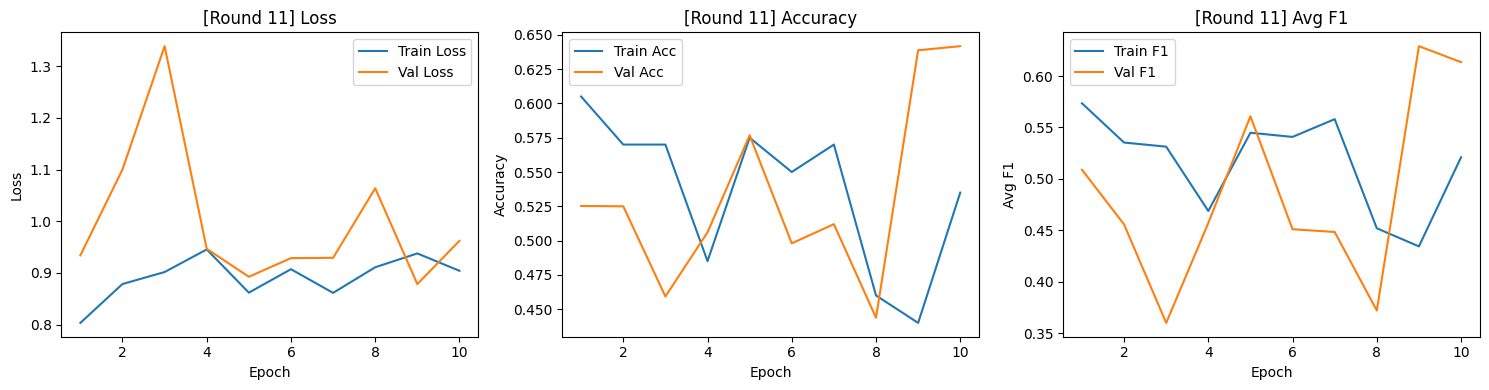


[AL Round 12/20] — Labeled samples: 210



Epoch 15/15
Train — Loss: 0.7534 | Acc: 0.6381 | Avg F1: 0.6194
Val   — Loss: 0.7404 | Acc: 0.7402 | Avg F1: 0.7312


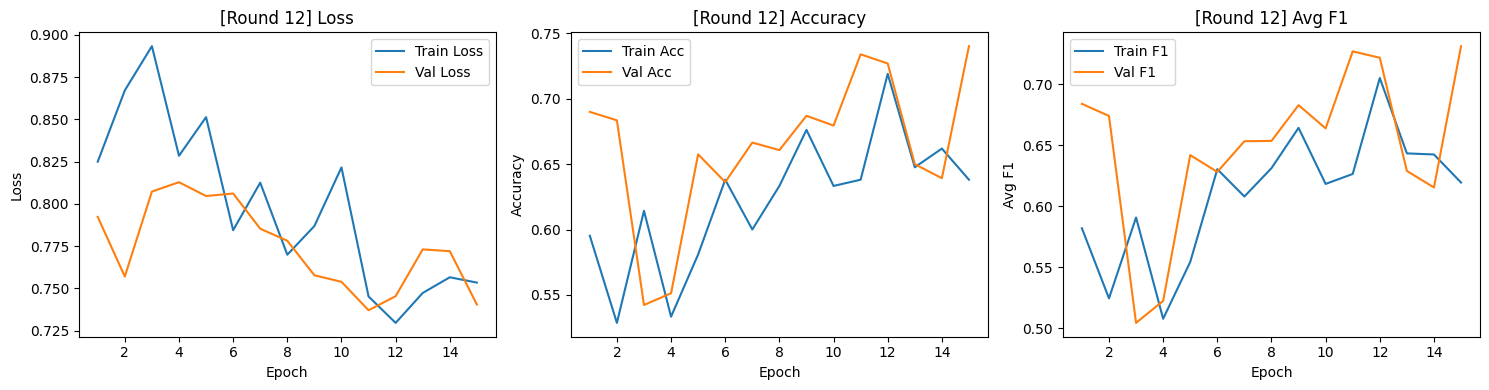


[AL Round 13/20] — Labeled samples: 220



Epoch 15/15
Train — Loss: 0.7406 | Acc: 0.7227 | Avg F1: 0.7289
Val   — Loss: 1.0462 | Acc: 0.5693 | Avg F1: 0.5619


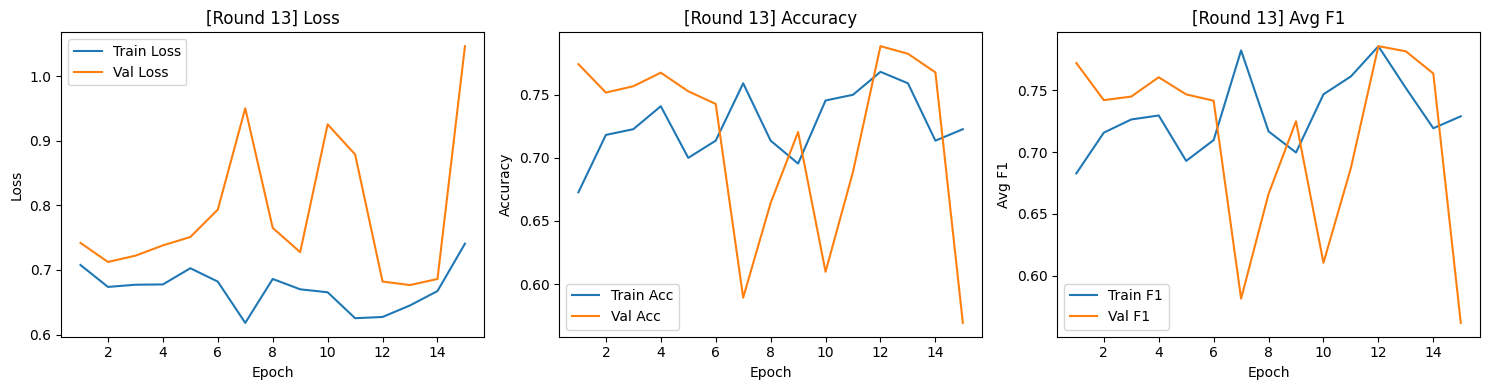


[AL Round 14/20] — Labeled samples: 230



Epoch 15/15
Train — Loss: 0.7331 | Acc: 0.7783 | Avg F1: 0.7542
Val   — Loss: 0.7024 | Acc: 0.7147 | Avg F1: 0.7012


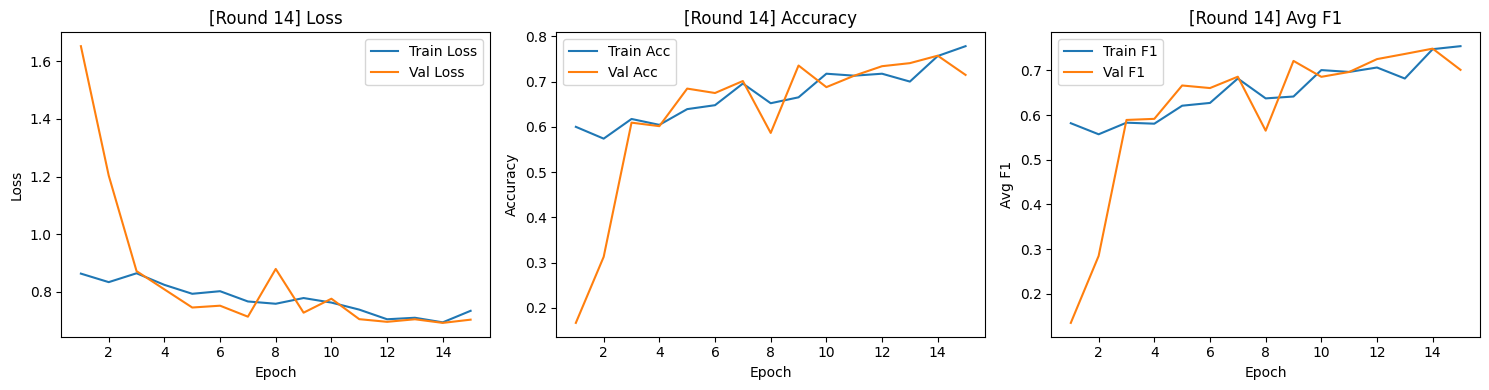


[AL Round 15/20] — Labeled samples: 240



Epoch 15/15
Train — Loss: 0.7477 | Acc: 0.7000 | Avg F1: 0.6996
Val   — Loss: 0.6991 | Acc: 0.7250 | Avg F1: 0.7152


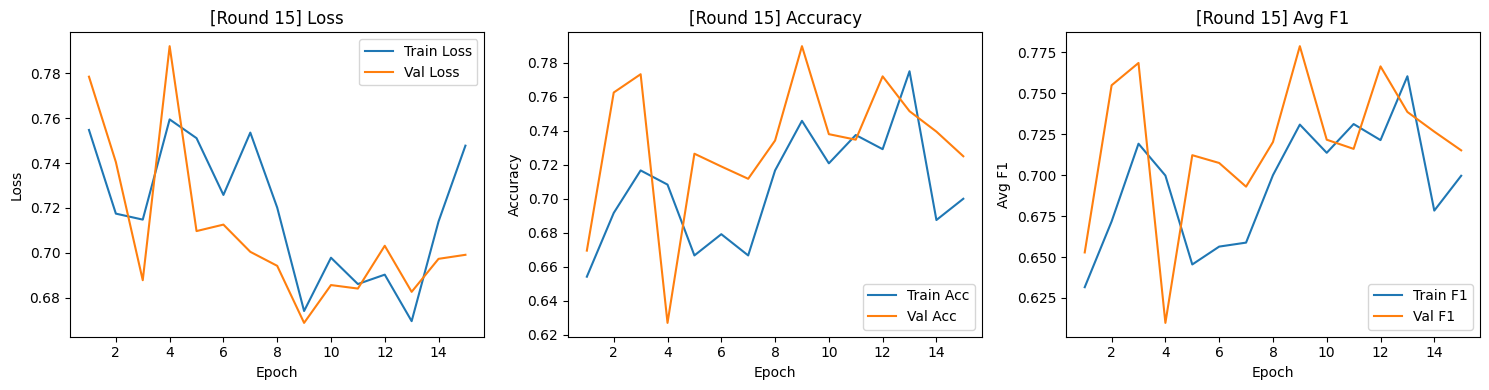


[AL Round 16/20] — Labeled samples: 250



Epoch 15/15
Train — Loss: 0.6664 | Acc: 0.8040 | Avg F1: 0.8063
Val   — Loss: 0.6837 | Acc: 0.7955 | Avg F1: 0.7877


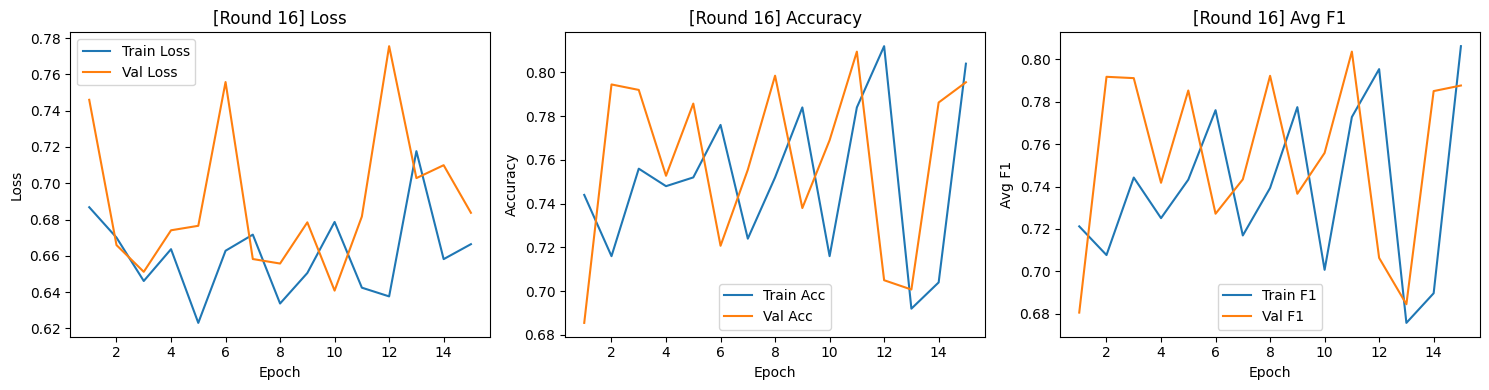


[AL Round 17/20] — Labeled samples: 260



Epoch 15/15
Train — Loss: 0.8388 | Acc: 0.5538 | Avg F1: 0.5375
Val   — Loss: 0.7953 | Acc: 0.6310 | Avg F1: 0.6181


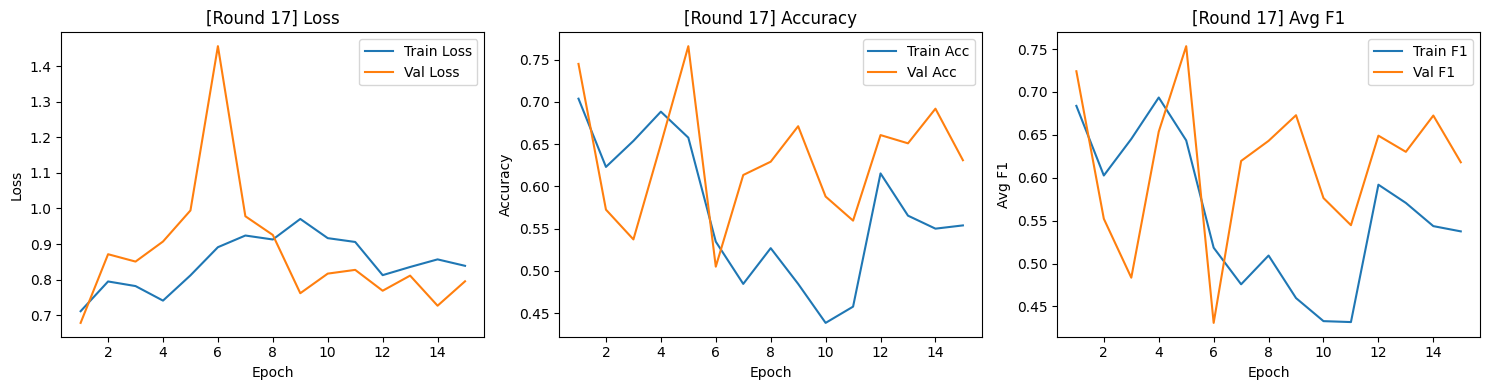


[AL Round 18/20] — Labeled samples: 270



Epoch 15/15
Train — Loss: 0.7724 | Acc: 0.6778 | Avg F1: 0.6662
Val   — Loss: 0.6551 | Acc: 0.7698 | Avg F1: 0.7741


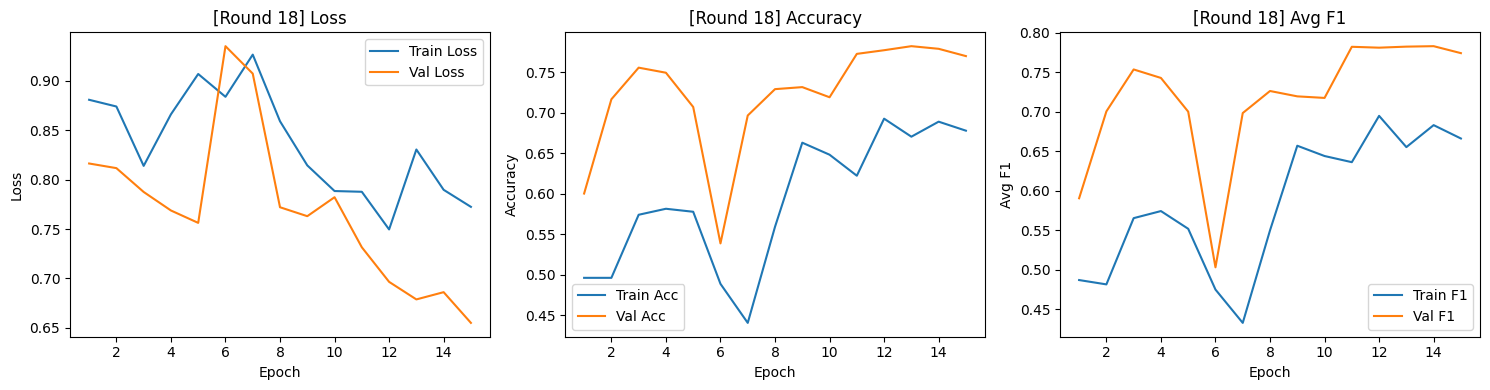


[AL Round 19/20] — Labeled samples: 280



Epoch 15/15
Train — Loss: 0.8017 | Acc: 0.6643 | Avg F1: 0.6439
Val   — Loss: 0.7137 | Acc: 0.7608 | Avg F1: 0.7589


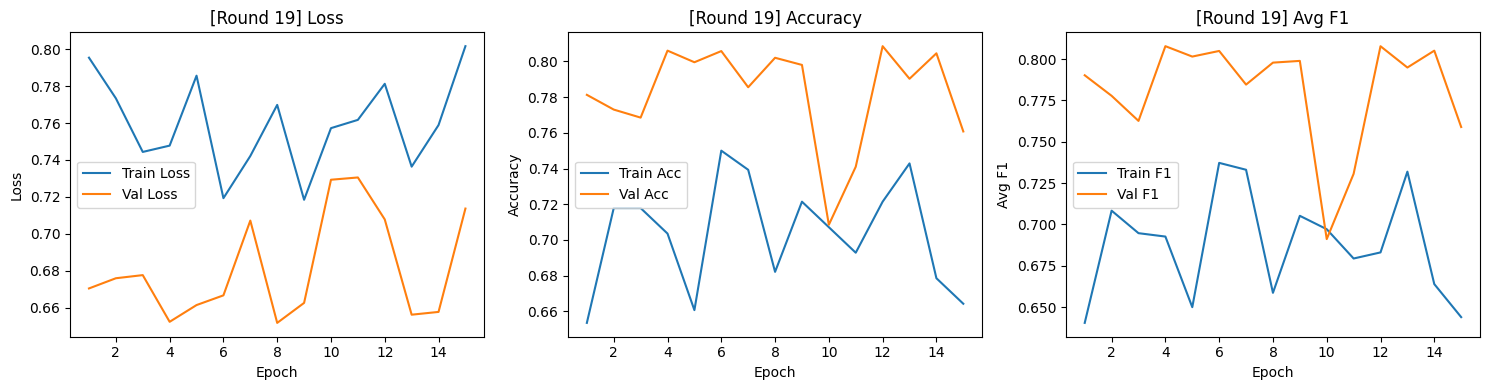


[AL Round 20/20] — Labeled samples: 290



Epoch 15/15
Train — Loss: 0.7066 | Acc: 0.7414 | Avg F1: 0.7334
Val   — Loss: 0.7296 | Acc: 0.7980 | Avg F1: 0.7880


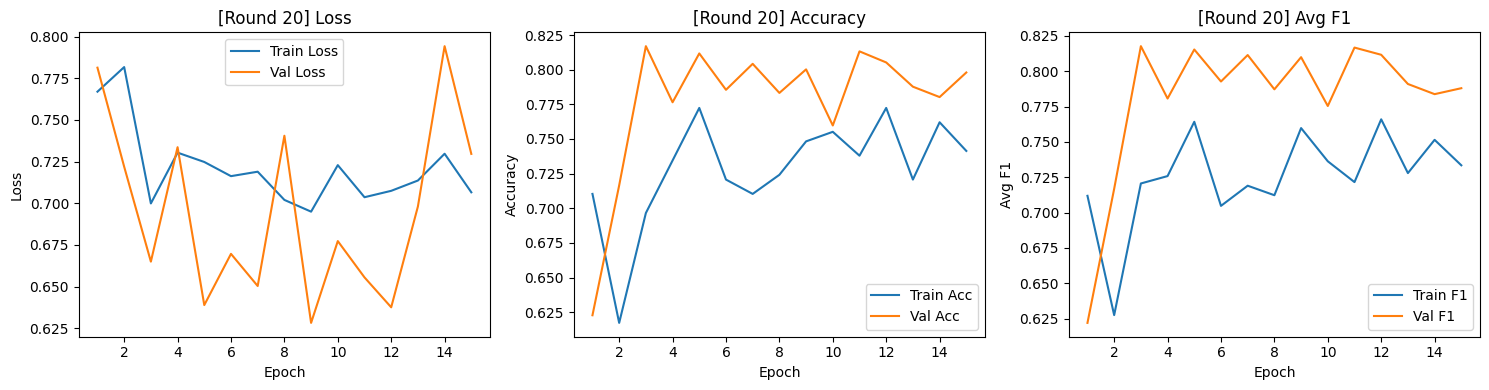

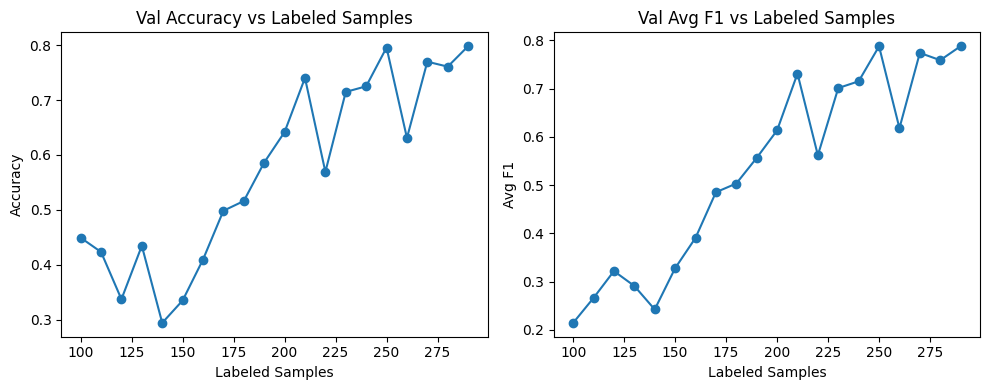


=== Running strategy: LEAST_CONFIDENT ===

[AL Round 1/20] — Labeled samples: 100



Epoch 5/5
Train — Loss: 2.5364 | Acc: 0.3500 | Avg F1: 0.3505
Val   — Loss: 703.6239 | Acc: 0.4153 | Avg F1: 0.1981


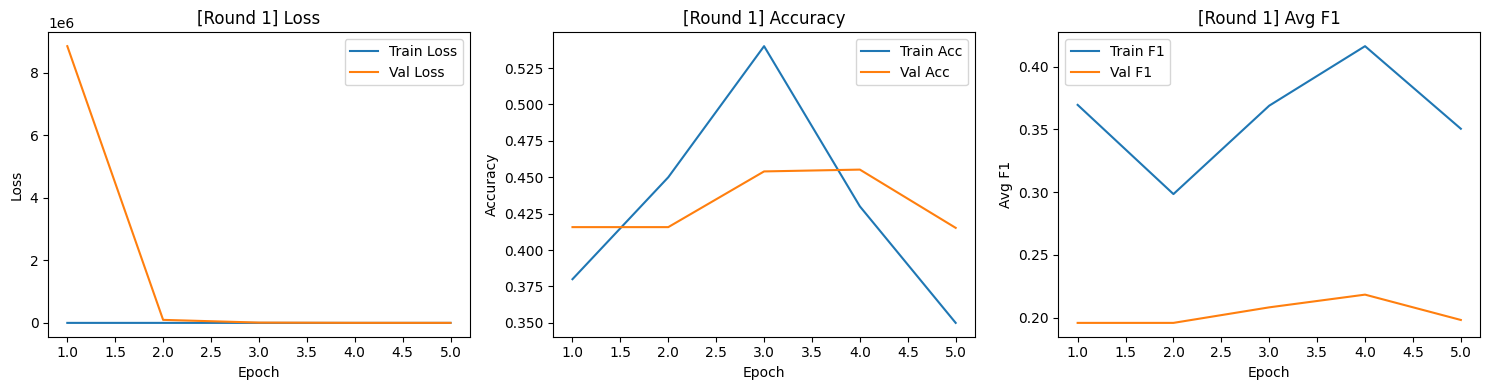


[AL Round 2/20] — Labeled samples: 110



Epoch 5/5
Train — Loss: 1.3907 | Acc: 0.2909 | Avg F1: 0.2923
Val   — Loss: 4.4311 | Acc: 0.3705 | Avg F1: 0.2794


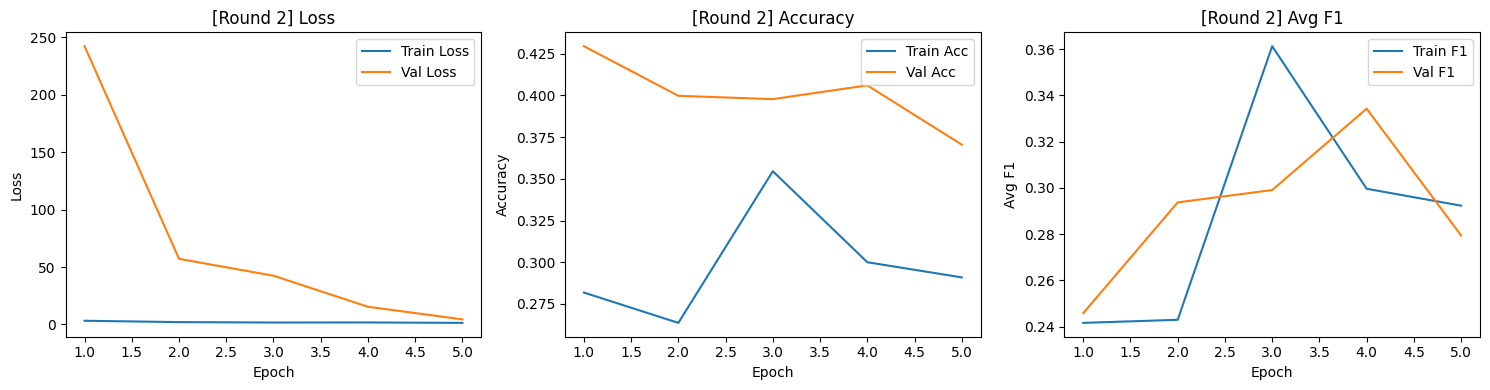


[AL Round 3/20] — Labeled samples: 120



Epoch 5/5
Train — Loss: 1.3103 | Acc: 0.3000 | Avg F1: 0.2602
Val   — Loss: 2.4974 | Acc: 0.5132 | Avg F1: 0.3763


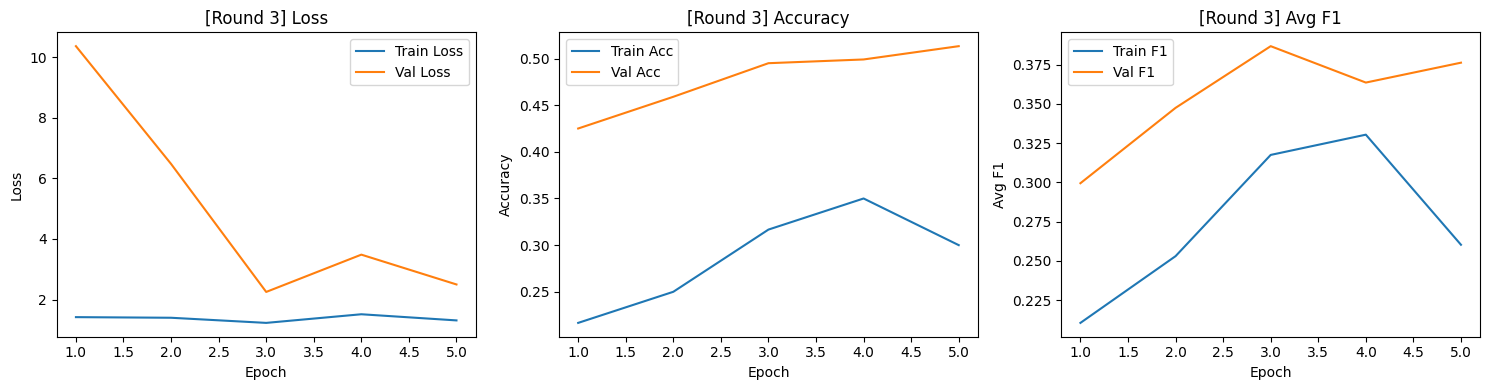


[AL Round 4/20] — Labeled samples: 130



Epoch 5/5
Train — Loss: 1.5190 | Acc: 0.2231 | Avg F1: 0.1839
Val   — Loss: 1.2094 | Acc: 0.3670 | Avg F1: 0.2703


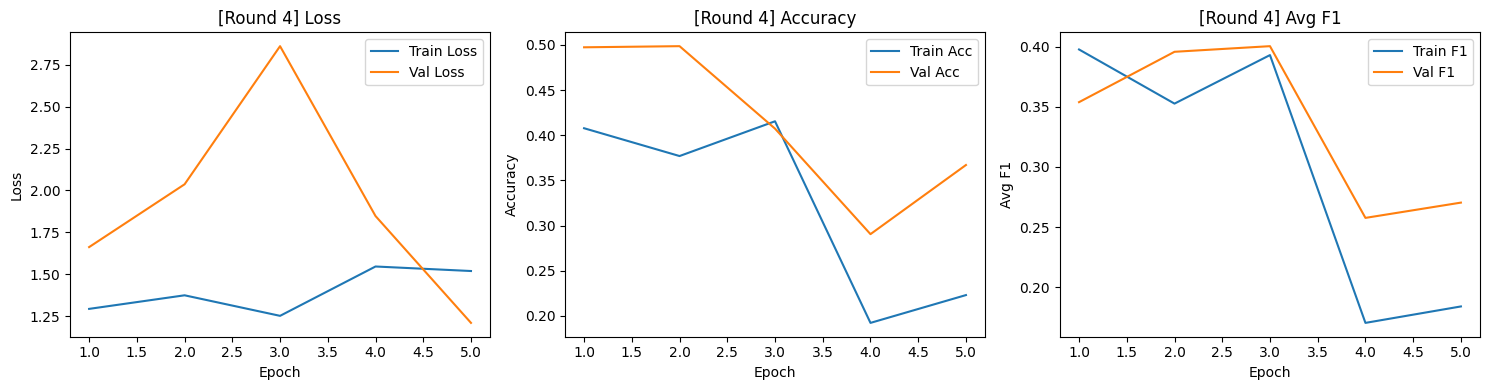


[AL Round 5/20] — Labeled samples: 140



Epoch 10/10
Train — Loss: 1.0702 | Acc: 0.3571 | Avg F1: 0.3561
Val   — Loss: 1.0472 | Acc: 0.4300 | Avg F1: 0.3652


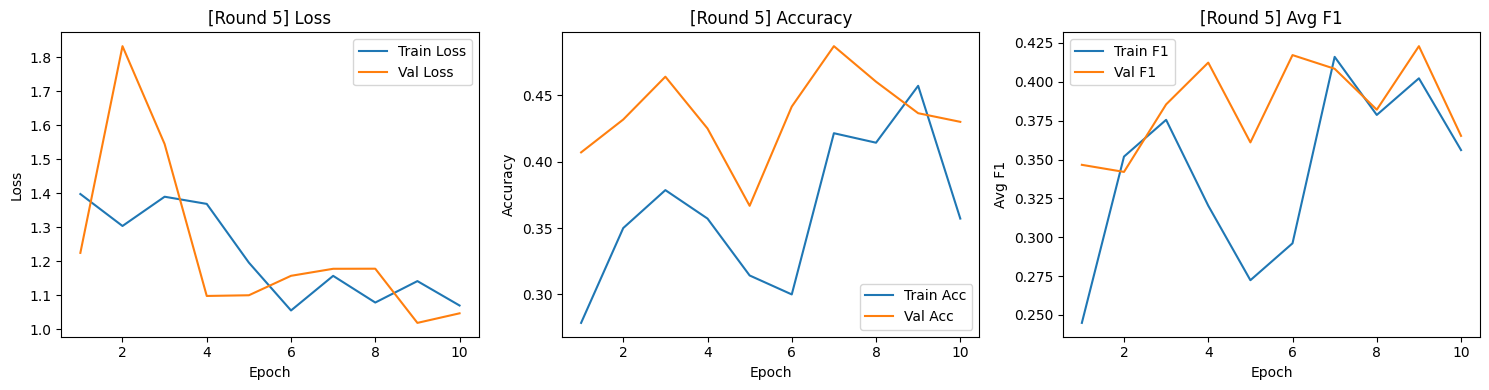


[AL Round 6/20] — Labeled samples: 150



Epoch 10/10
Train — Loss: 1.0963 | Acc: 0.3867 | Avg F1: 0.3776
Val   — Loss: 0.9549 | Acc: 0.4565 | Avg F1: 0.4530


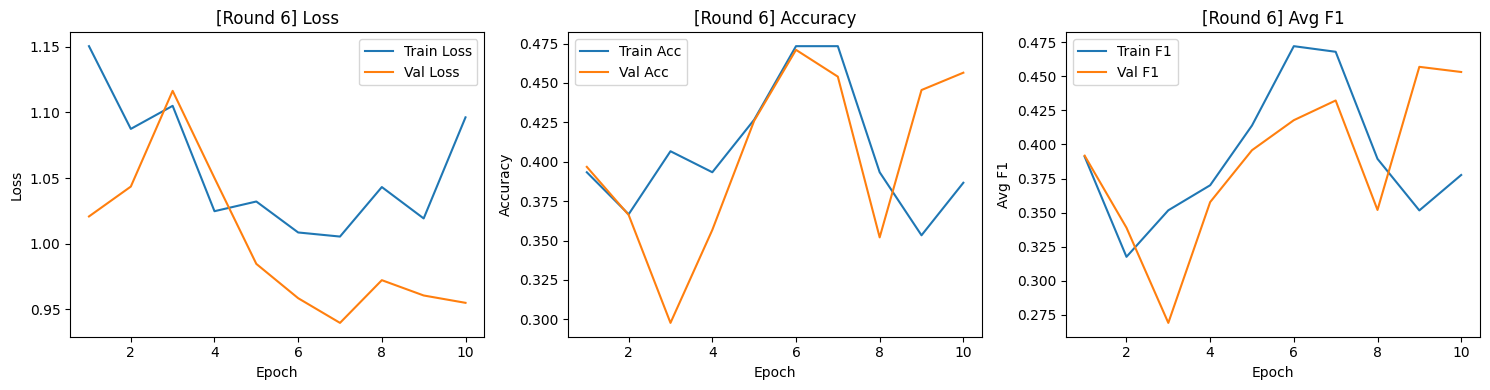


[AL Round 7/20] — Labeled samples: 160



Epoch 10/10
Train — Loss: 0.9143 | Acc: 0.5125 | Avg F1: 0.5162
Val   — Loss: 0.8836 | Acc: 0.4565 | Avg F1: 0.3941


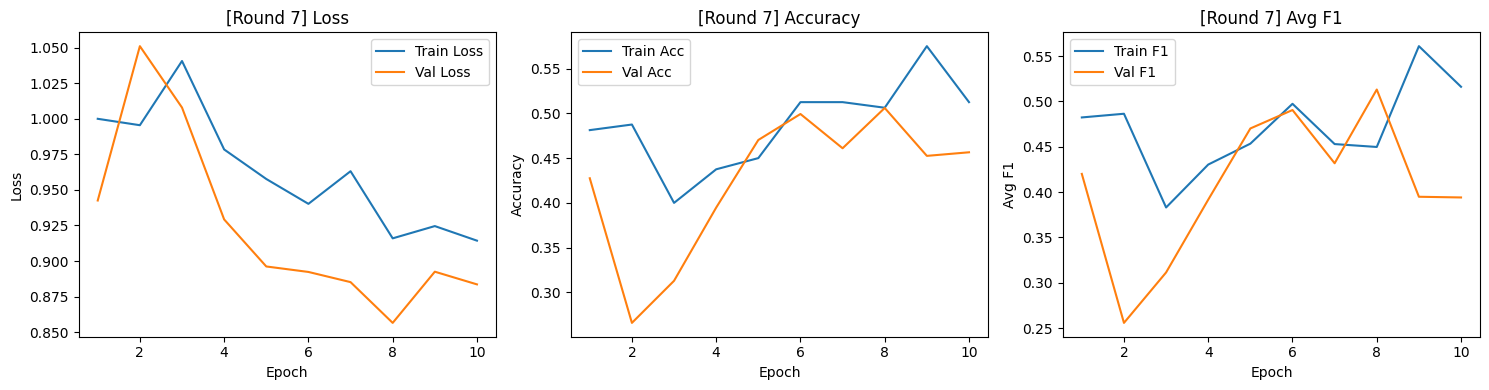


[AL Round 8/20] — Labeled samples: 170



Epoch 10/10
Train — Loss: 0.8212 | Acc: 0.5882 | Avg F1: 0.5707
Val   — Loss: 0.8279 | Acc: 0.5298 | Avg F1: 0.5191


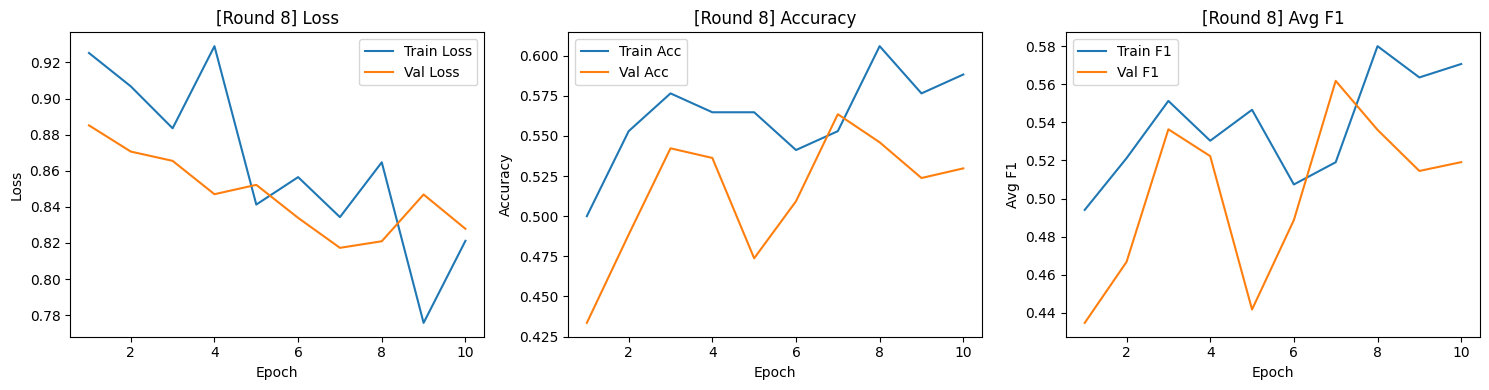


[AL Round 9/20] — Labeled samples: 180



Epoch 10/10
Train — Loss: 0.7541 | Acc: 0.6278 | Avg F1: 0.6225
Val   — Loss: 0.8500 | Acc: 0.5480 | Avg F1: 0.5314


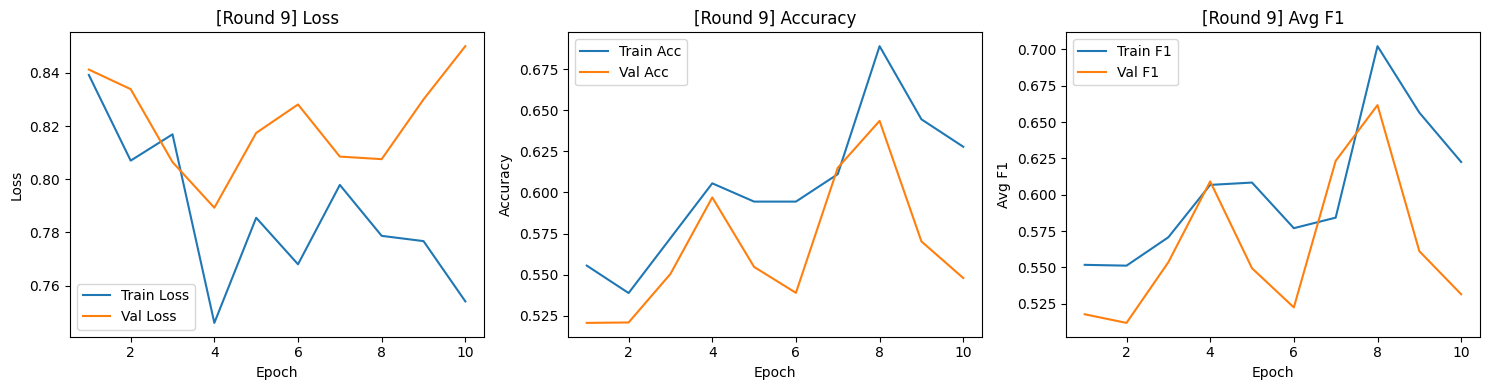


[AL Round 10/20] — Labeled samples: 190



Epoch 10/10
Train — Loss: 0.8484 | Acc: 0.5947 | Avg F1: 0.6096
Val   — Loss: 0.7931 | Acc: 0.5897 | Avg F1: 0.5901


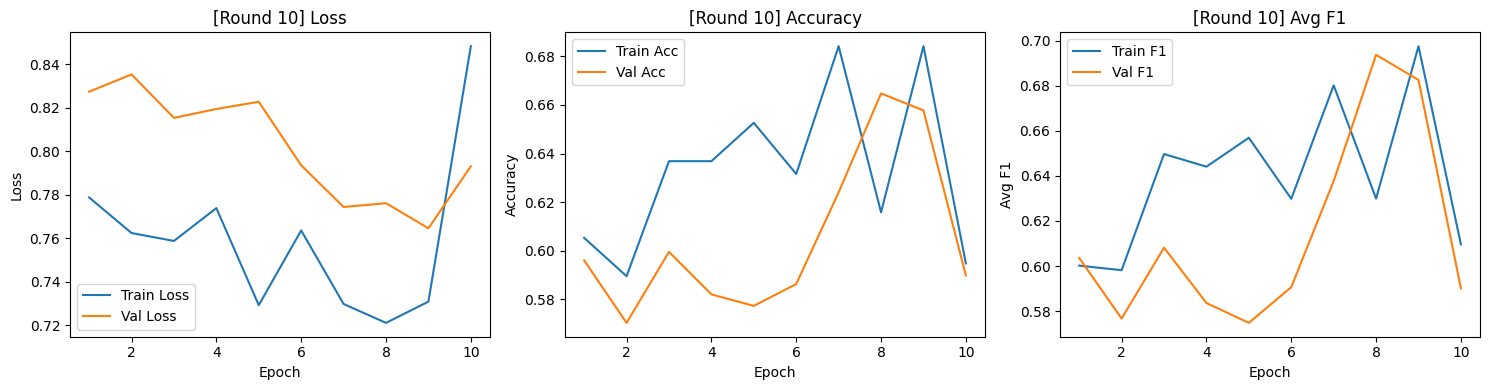


[AL Round 11/20] — Labeled samples: 200



Epoch 10/10
Train — Loss: 0.7946 | Acc: 0.6100 | Avg F1: 0.6054
Val   — Loss: 0.8484 | Acc: 0.6005 | Avg F1: 0.6176


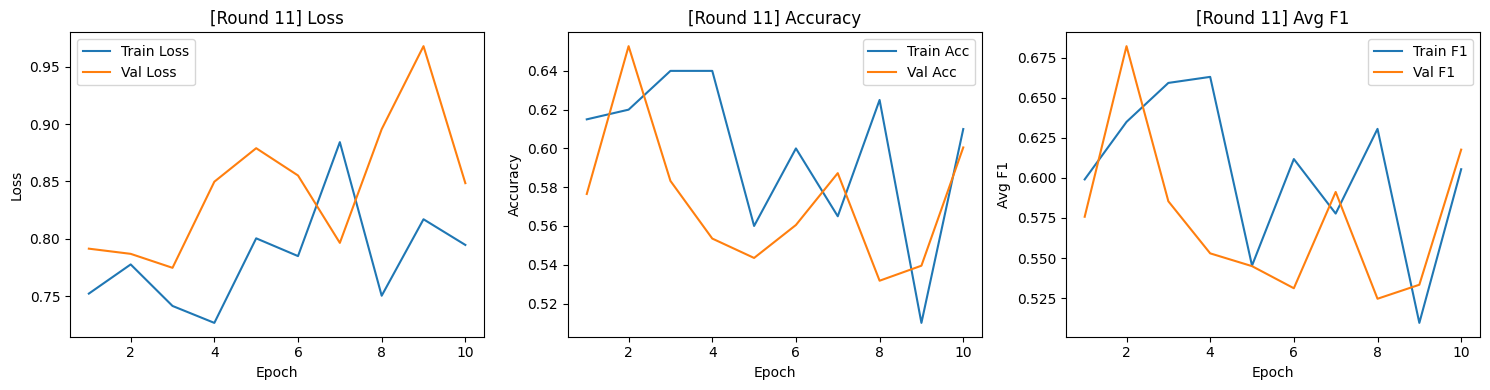


[AL Round 12/20] — Labeled samples: 210



Epoch 15/15
Train — Loss: 0.7994 | Acc: 0.6333 | Avg F1: 0.6395
Val   — Loss: 0.7624 | Acc: 0.6060 | Avg F1: 0.6016


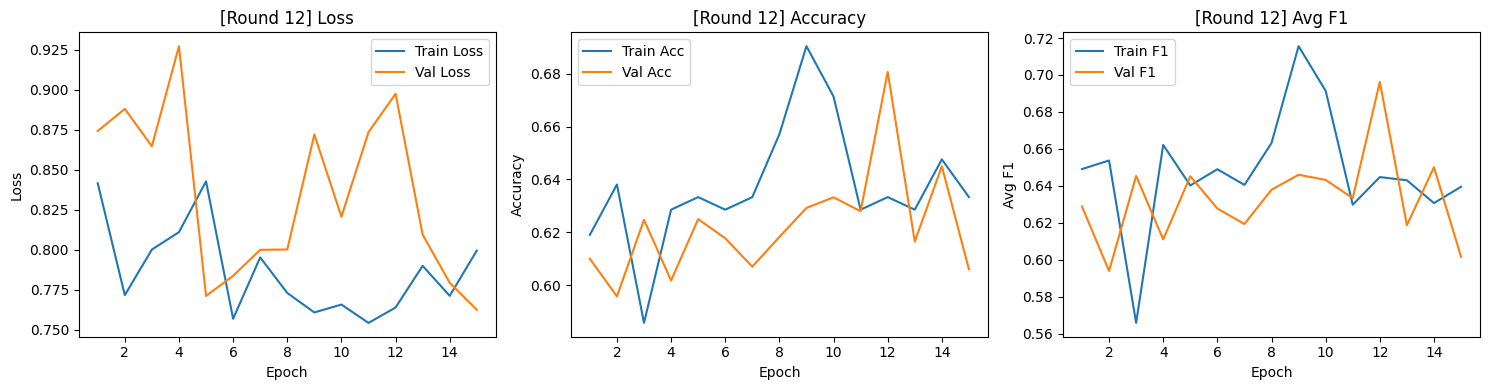


[AL Round 13/20] — Labeled samples: 220



Epoch 15/15
Train — Loss: 0.7427 | Acc: 0.6636 | Avg F1: 0.6652
Val   — Loss: 0.8390 | Acc: 0.6855 | Avg F1: 0.6928


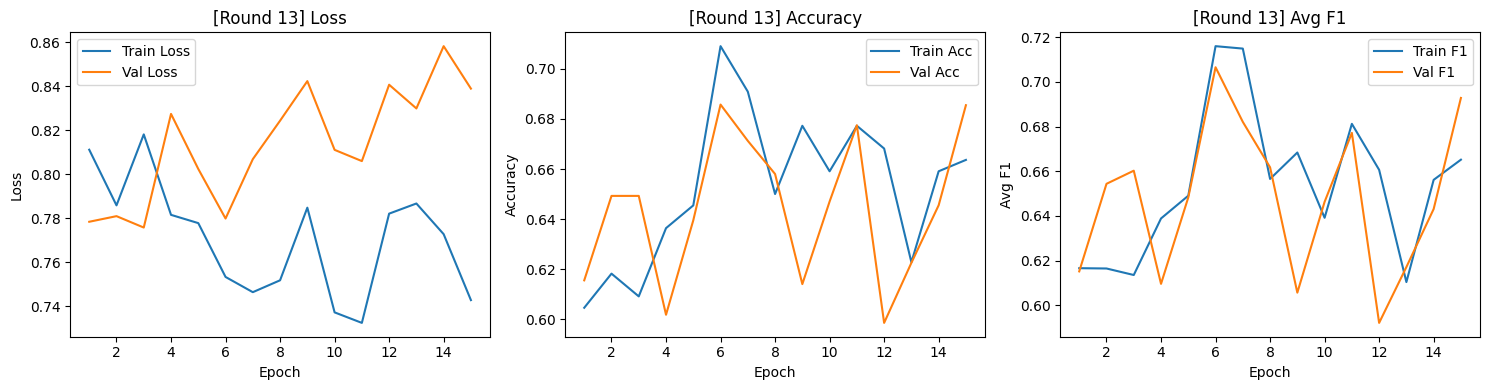


[AL Round 14/20] — Labeled samples: 230



Epoch 15/15
Train — Loss: 0.6834 | Acc: 0.6826 | Avg F1: 0.6682
Val   — Loss: 0.7410 | Acc: 0.7302 | Avg F1: 0.7365


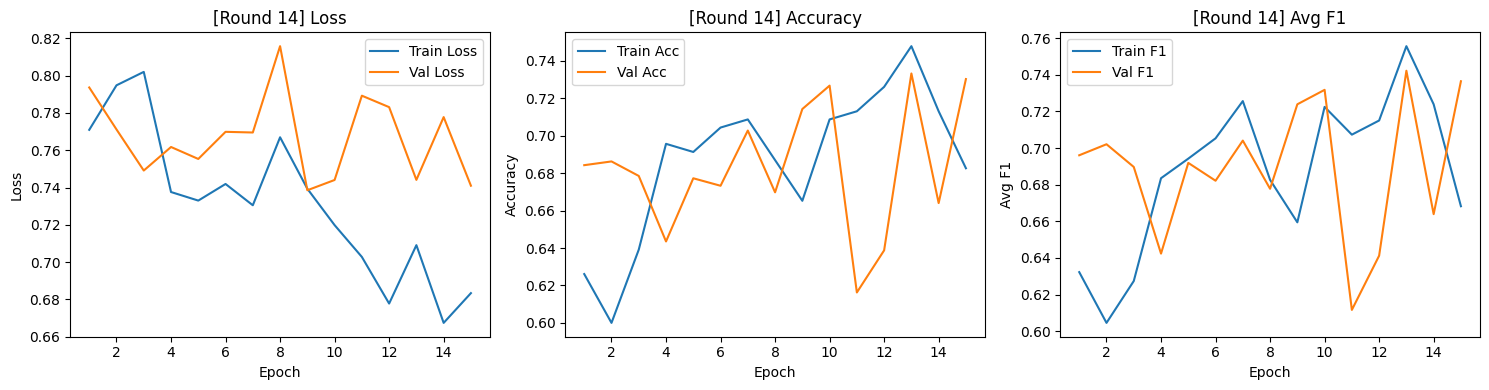


[AL Round 15/20] — Labeled samples: 240



Epoch 15/15
Train — Loss: 0.6595 | Acc: 0.7708 | Avg F1: 0.7760
Val   — Loss: 0.7229 | Acc: 0.7378 | Avg F1: 0.7536


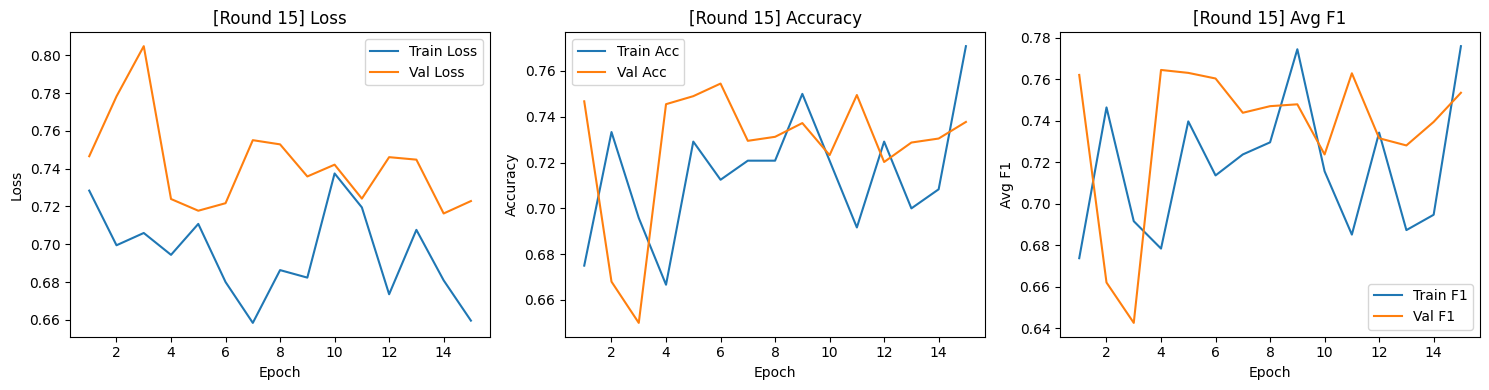


[AL Round 16/20] — Labeled samples: 250



Epoch 15/15
Train — Loss: 0.6223 | Acc: 0.8000 | Avg F1: 0.8120
Val   — Loss: 0.8375 | Acc: 0.7113 | Avg F1: 0.7283


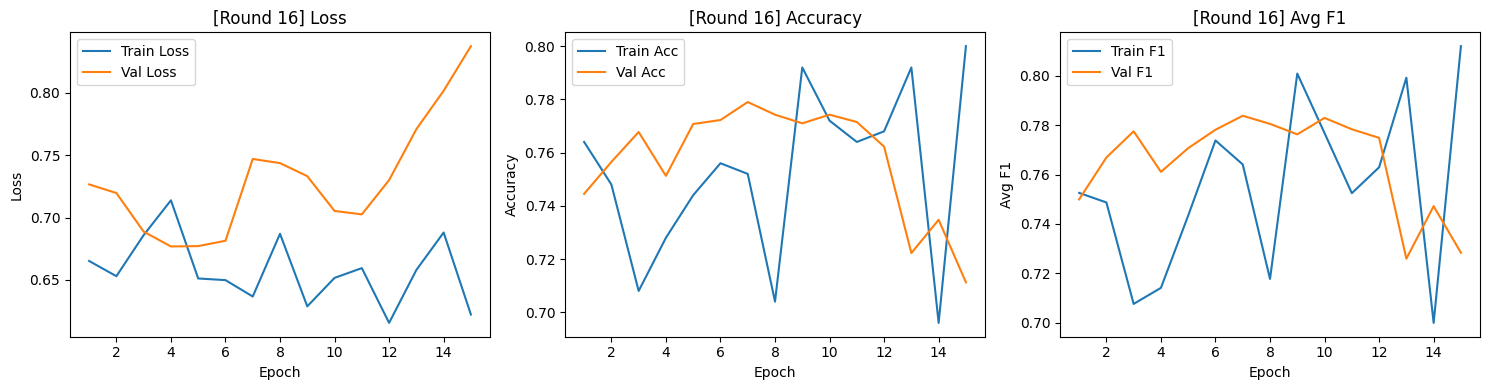


[AL Round 17/20] — Labeled samples: 260



Epoch 15/15
Train — Loss: 0.8927 | Acc: 0.5346 | Avg F1: 0.5500
Val   — Loss: 0.7739 | Acc: 0.5605 | Avg F1: 0.5384


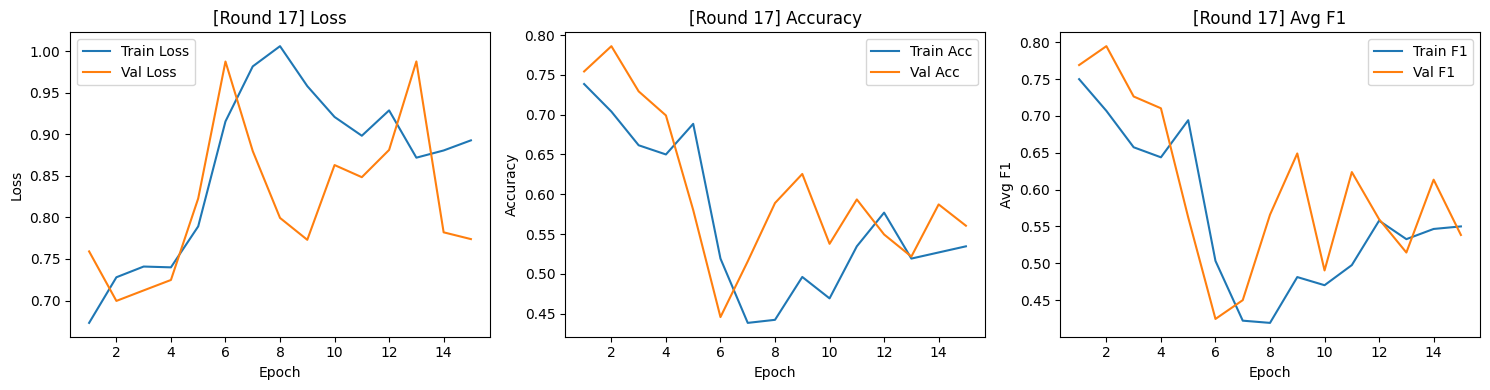


[AL Round 18/20] — Labeled samples: 270



Epoch 15/15
Train — Loss: 0.9808 | Acc: 0.5630 | Avg F1: 0.5567
Val   — Loss: 0.8629 | Acc: 0.6308 | Avg F1: 0.6332


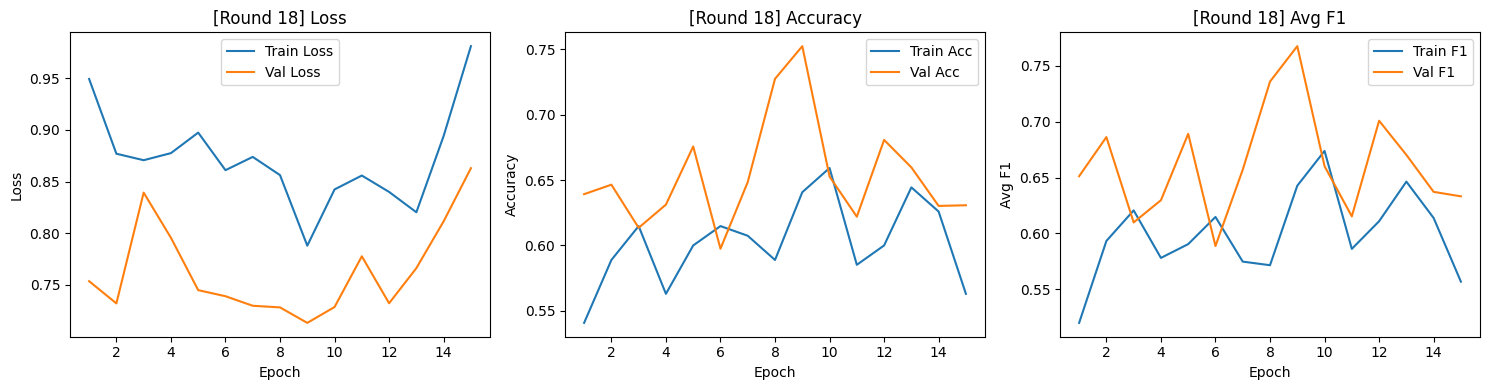


[AL Round 19/20] — Labeled samples: 280



Epoch 15/15
Train — Loss: 0.8515 | Acc: 0.6679 | Avg F1: 0.6557
Val   — Loss: 0.7291 | Acc: 0.7565 | Avg F1: 0.7687


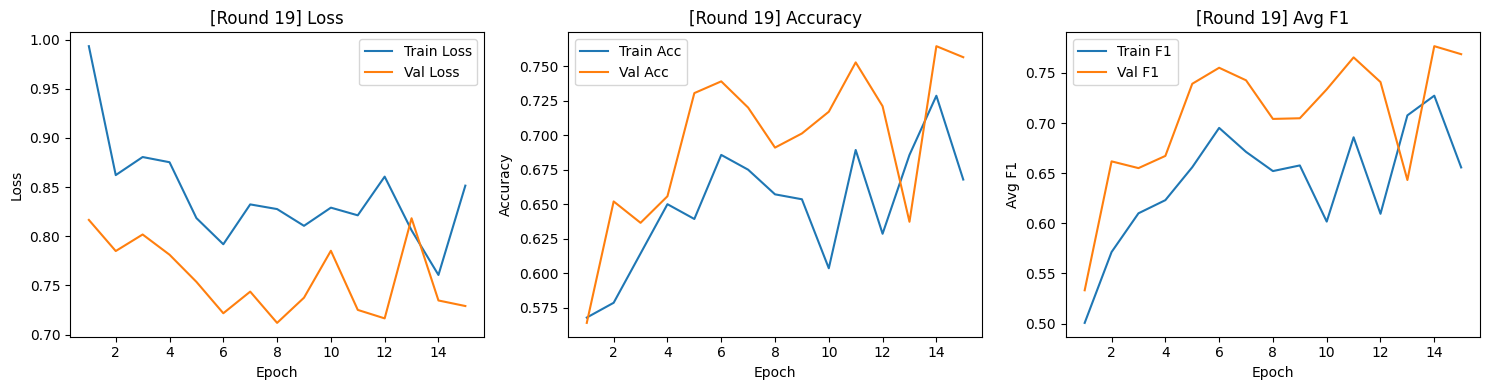


[AL Round 20/20] — Labeled samples: 290



Epoch 15/15
Train — Loss: 0.7736 | Acc: 0.7138 | Avg F1: 0.7226
Val   — Loss: 0.7318 | Acc: 0.7190 | Avg F1: 0.7353


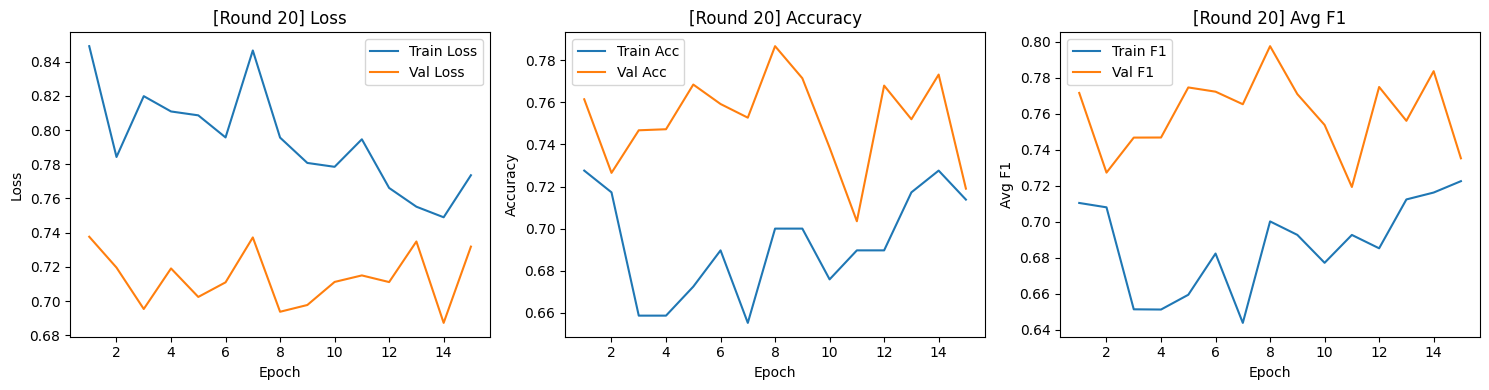

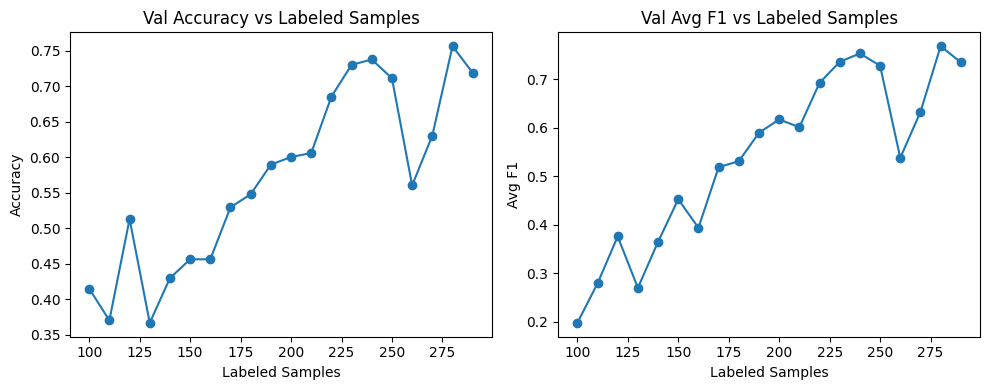

X_labeled shape: (300, 6, 28)
y_labeled shape: (300,)
X_unlabeled shape: (15700, 6, 28)
y_unlabeled shape: (15700,)

=== Running strategy: MARGIN ===

[AL Round 1/20] — Labeled samples: 300



Epoch 5/5
Train — Loss: 1.2478 | Acc: 0.3767 | Avg F1: 0.3525
Val   — Loss: 14.6025 | Acc: 0.4145 | Avg F1: 0.3355


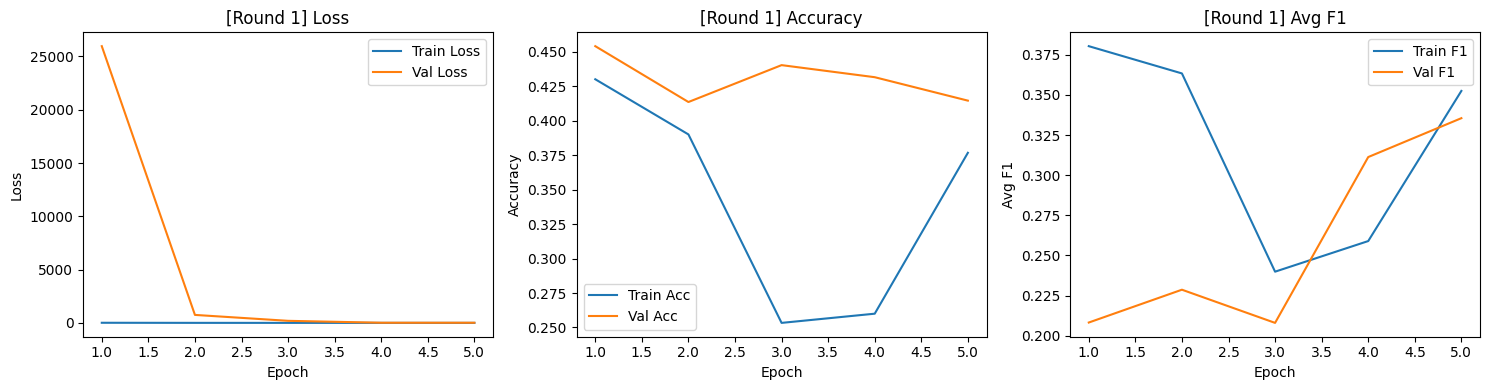


[AL Round 2/20] — Labeled samples: 310



Epoch 5/5
Train — Loss: 1.0760 | Acc: 0.4194 | Avg F1: 0.3852
Val   — Loss: 1.1825 | Acc: 0.4115 | Avg F1: 0.3204


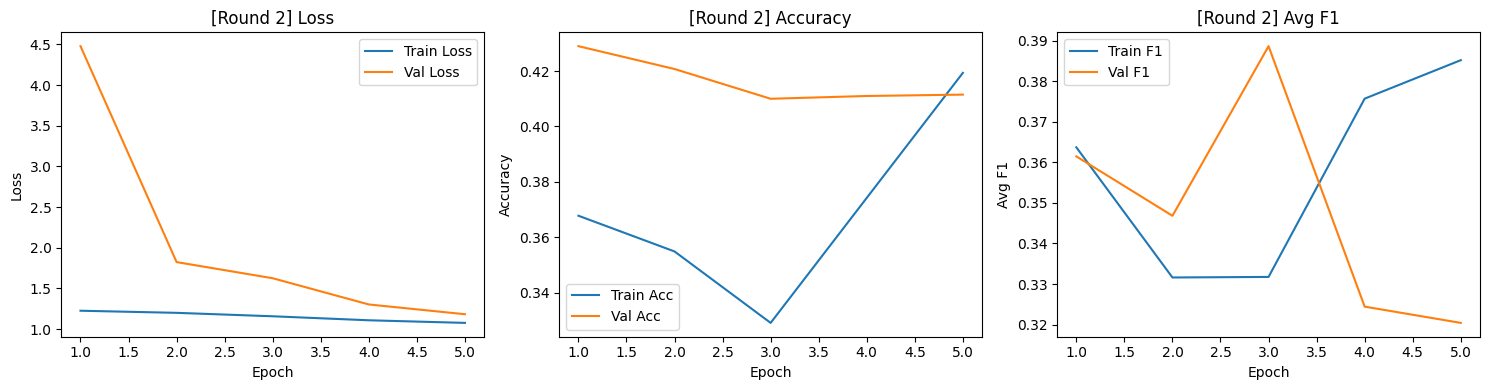


[AL Round 3/20] — Labeled samples: 320



Epoch 5/5
Train — Loss: 1.0116 | Acc: 0.3937 | Avg F1: 0.3890
Val   — Loss: 1.0193 | Acc: 0.4627 | Avg F1: 0.4049


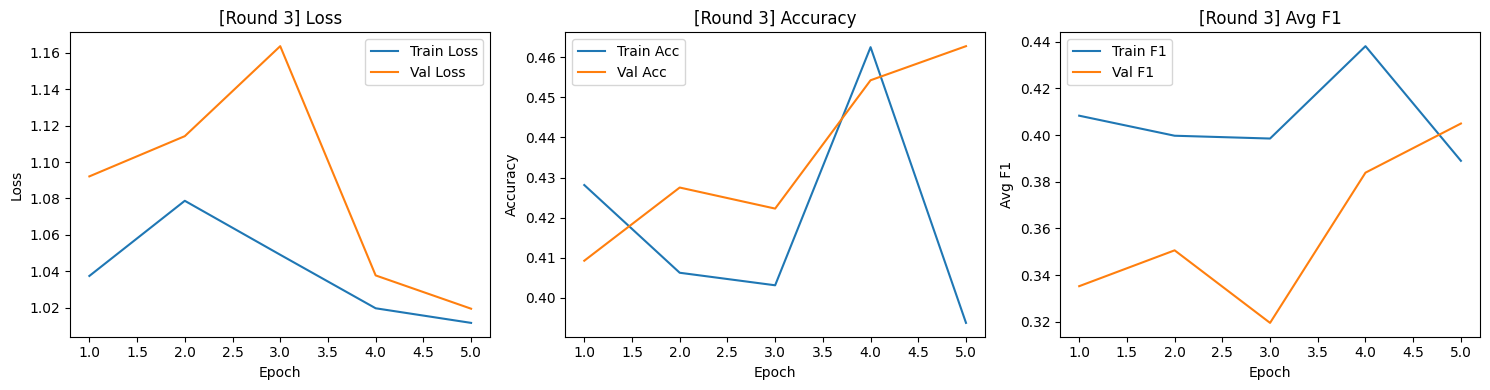


[AL Round 4/20] — Labeled samples: 330



Epoch 5/5
Train — Loss: 0.9326 | Acc: 0.5455 | Avg F1: 0.5446
Val   — Loss: 0.8438 | Acc: 0.5693 | Avg F1: 0.5465


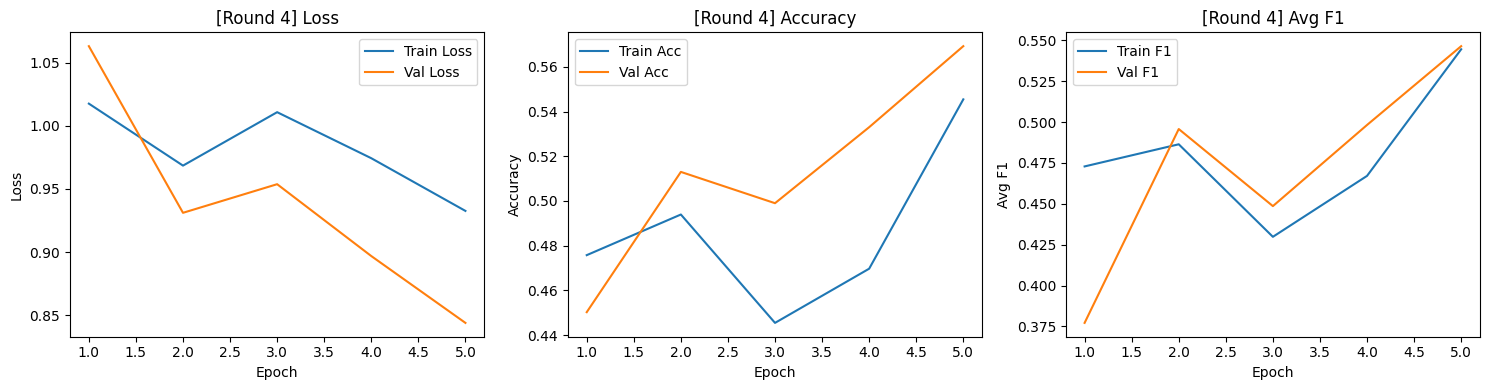


[AL Round 5/20] — Labeled samples: 340



Epoch 10/10
Train — Loss: 0.8298 | Acc: 0.6118 | Avg F1: 0.6109
Val   — Loss: 0.7732 | Acc: 0.6225 | Avg F1: 0.6142


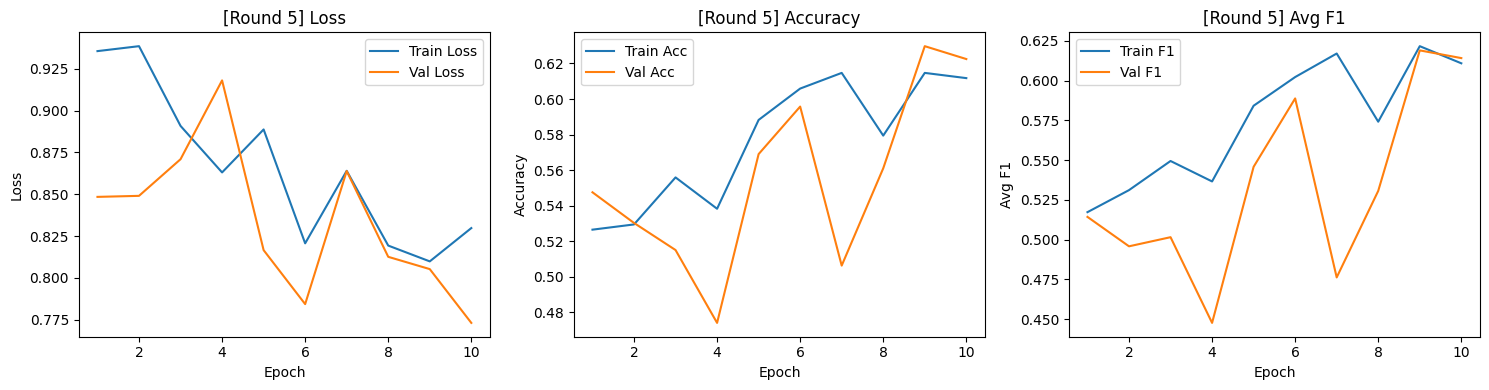


[AL Round 6/20] — Labeled samples: 350



Epoch 10/10
Train — Loss: 0.7262 | Acc: 0.6686 | Avg F1: 0.6695
Val   — Loss: 0.7381 | Acc: 0.6987 | Avg F1: 0.7052


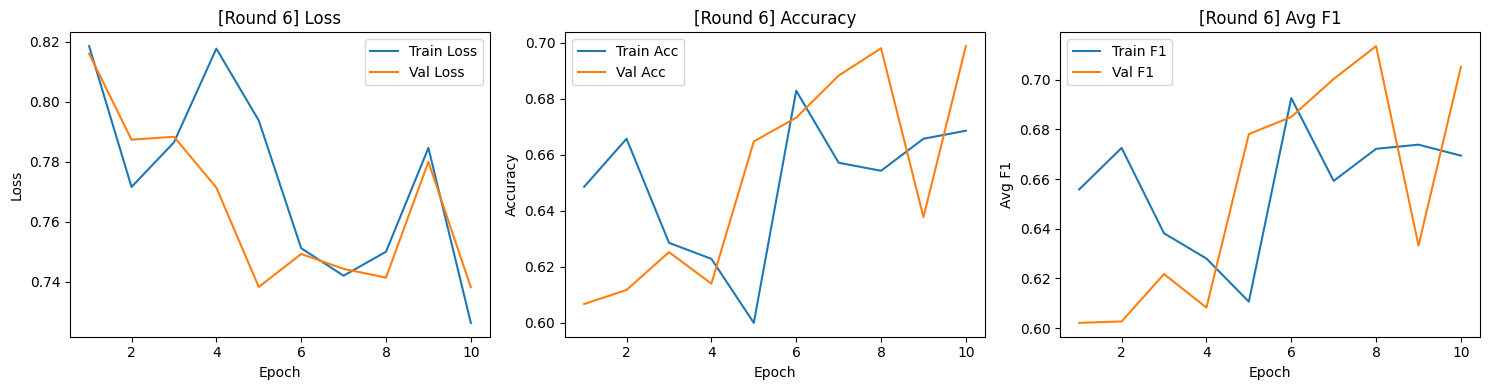


[AL Round 7/20] — Labeled samples: 360



Epoch 10/10
Train — Loss: 0.7003 | Acc: 0.7194 | Avg F1: 0.7431
Val   — Loss: 0.7434 | Acc: 0.7672 | Avg F1: 0.7719


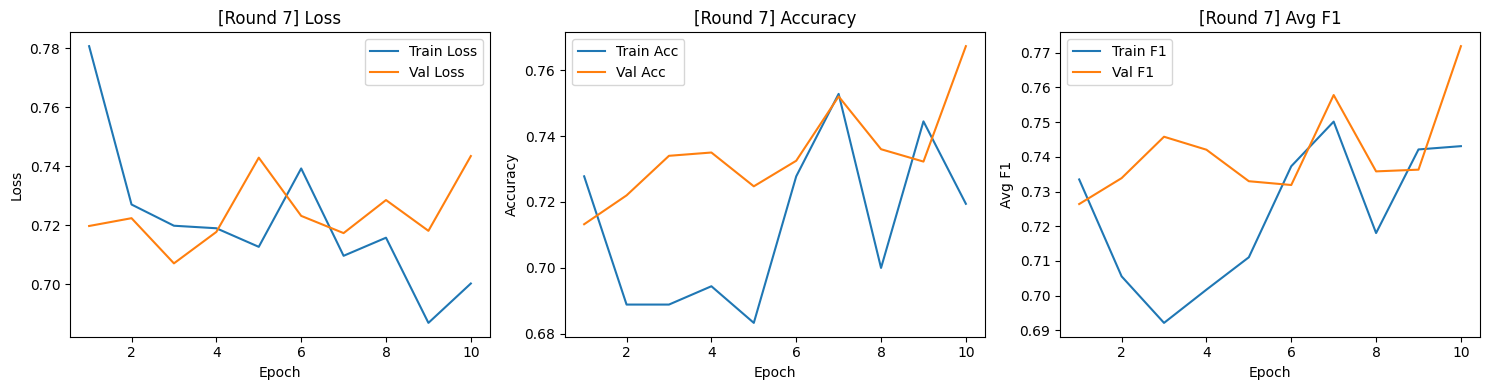


[AL Round 8/20] — Labeled samples: 370



Epoch 10/10
Train — Loss: 0.6744 | Acc: 0.7595 | Avg F1: 0.7608
Val   — Loss: 0.7625 | Acc: 0.7720 | Avg F1: 0.7775


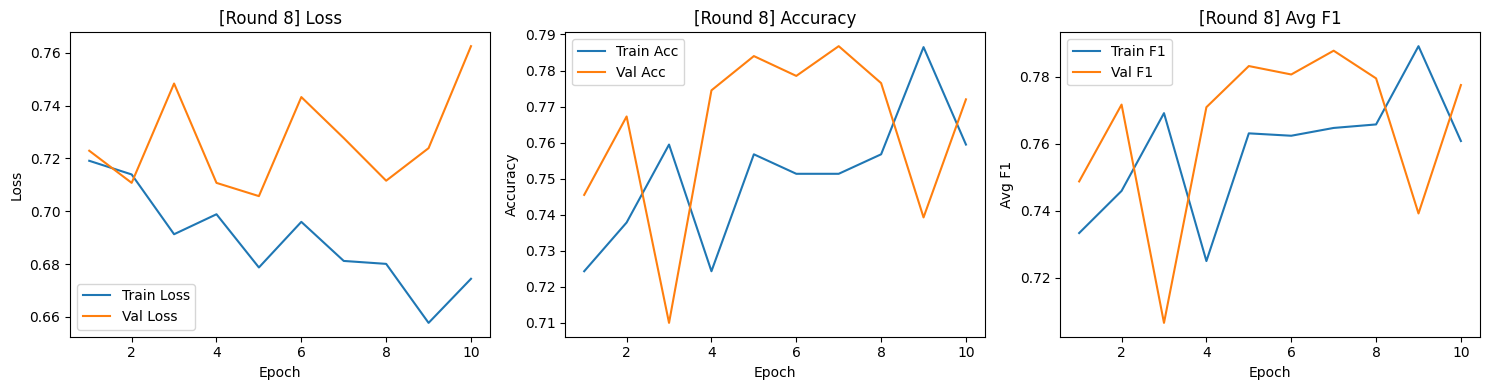


[AL Round 9/20] — Labeled samples: 380



Epoch 10/10
Train — Loss: 0.6663 | Acc: 0.7658 | Avg F1: 0.7793
Val   — Loss: 0.6548 | Acc: 0.7820 | Avg F1: 0.7831


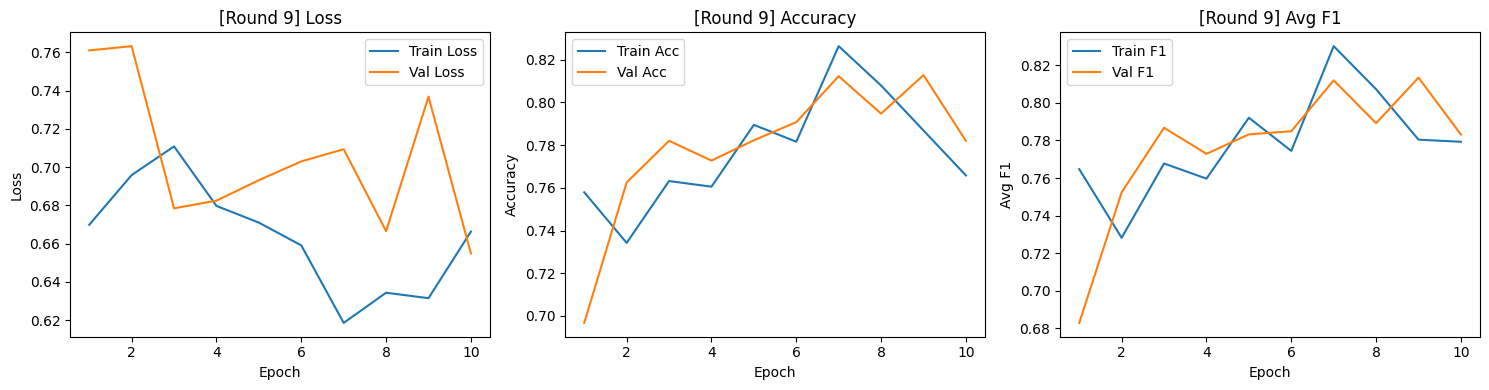


[AL Round 10/20] — Labeled samples: 390



Epoch 10/10
Train — Loss: 0.8309 | Acc: 0.5821 | Avg F1: 0.5706
Val   — Loss: 0.7705 | Acc: 0.7147 | Avg F1: 0.7203


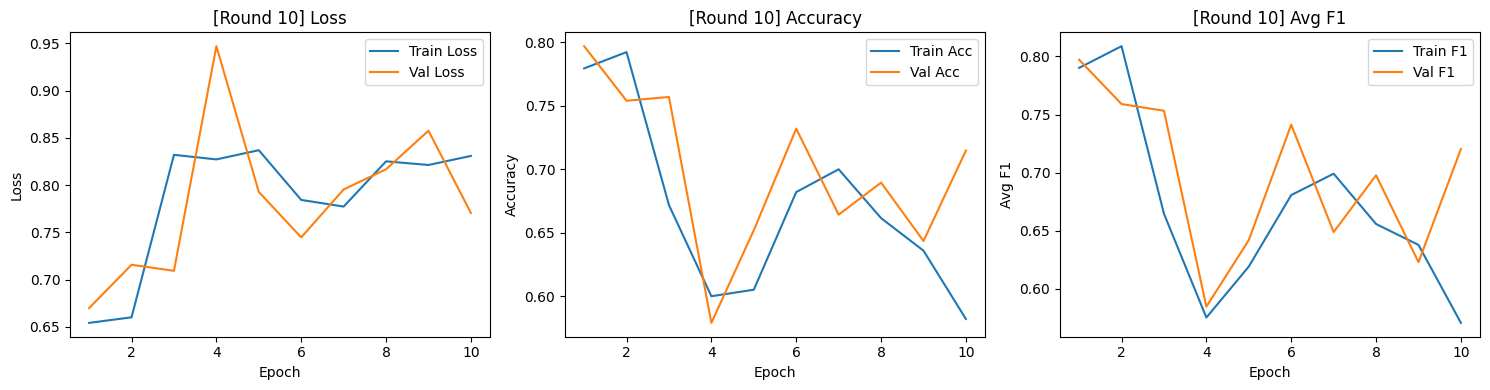


[AL Round 11/20] — Labeled samples: 400



Epoch 10/10
Train — Loss: 0.7284 | Acc: 0.7550 | Avg F1: 0.7664
Val   — Loss: 0.6761 | Acc: 0.7670 | Avg F1: 0.7792


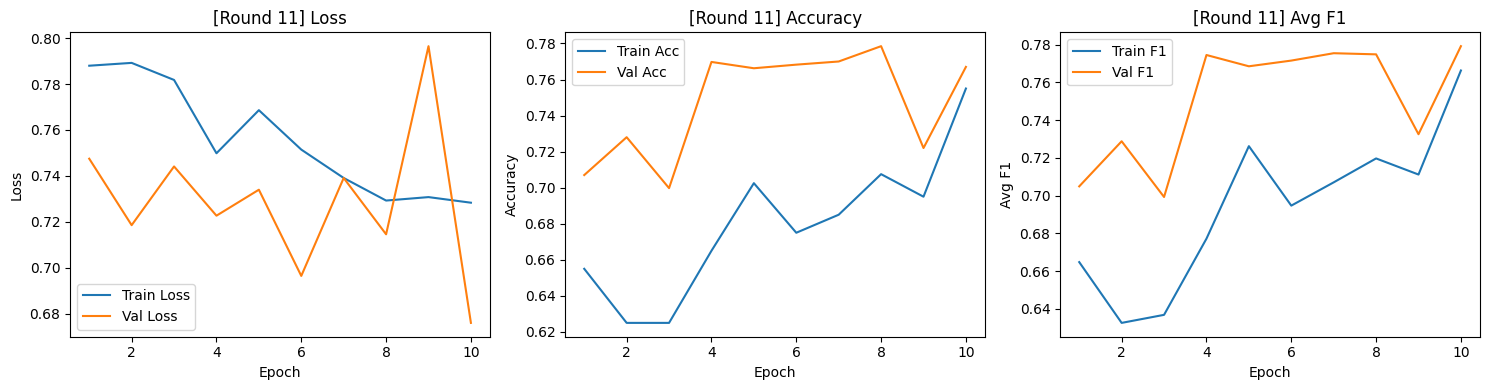


[AL Round 12/20] — Labeled samples: 410



Epoch 15/15
Train — Loss: 0.6282 | Acc: 0.8000 | Avg F1: 0.8088
Val   — Loss: 0.6736 | Acc: 0.7837 | Avg F1: 0.7821


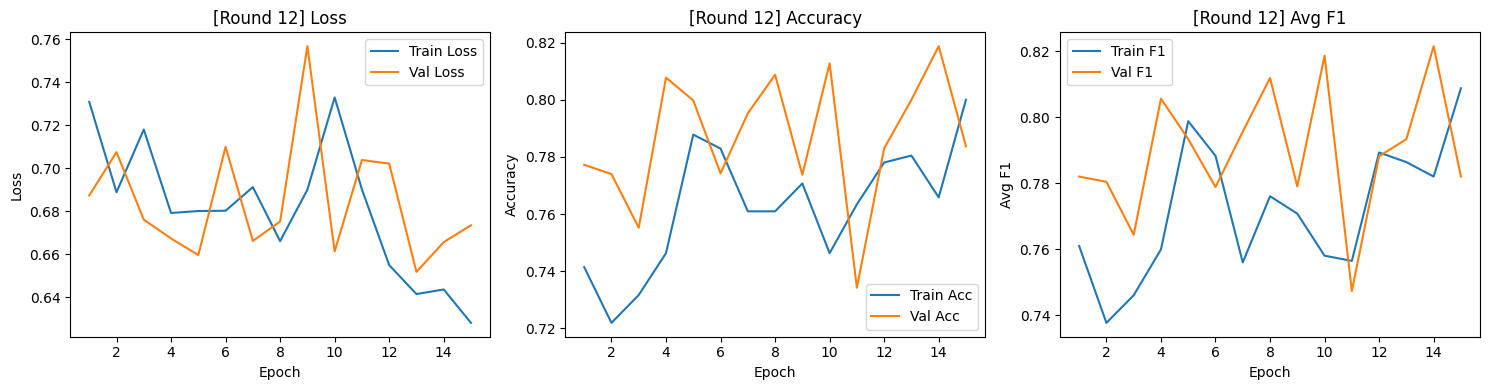


[AL Round 13/20] — Labeled samples: 420



Epoch 15/15
Train — Loss: 0.6354 | Acc: 0.8143 | Avg F1: 0.8213
Val   — Loss: 1.1620 | Acc: 0.6278 | Avg F1: 0.6168


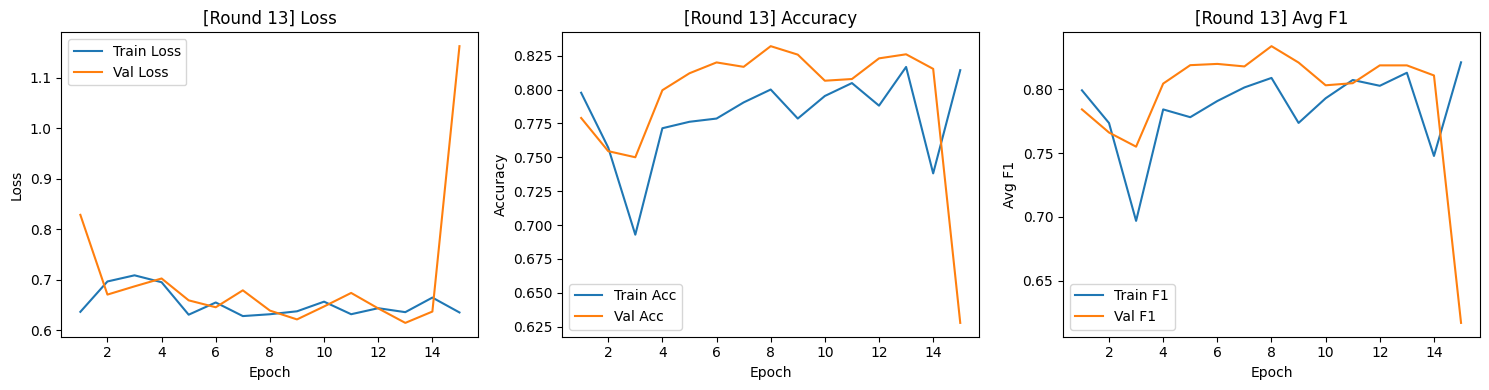


[AL Round 14/20] — Labeled samples: 430



Epoch 15/15
Train — Loss: 0.6265 | Acc: 0.8070 | Avg F1: 0.8121
Val   — Loss: 0.6733 | Acc: 0.8090 | Avg F1: 0.8112


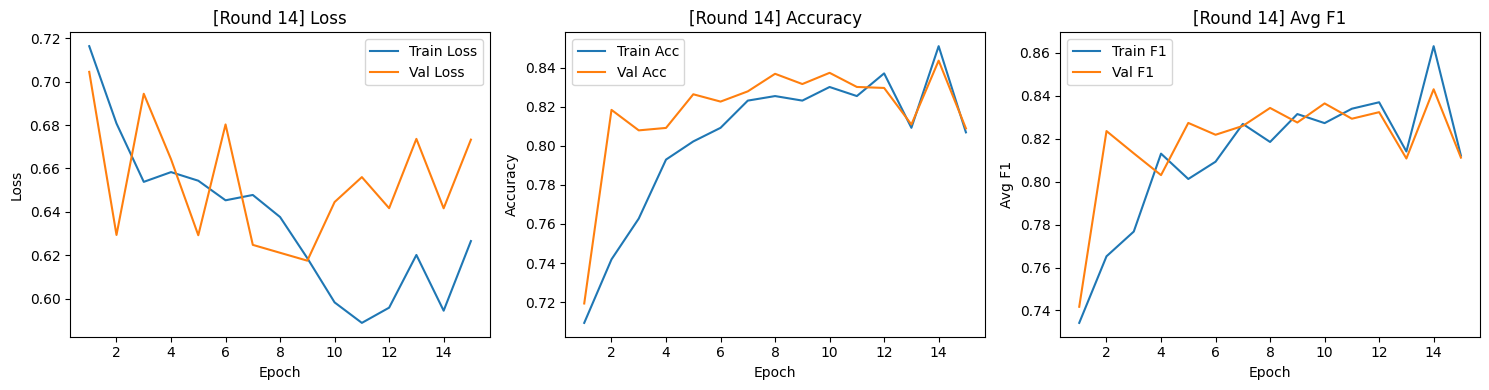


[AL Round 15/20] — Labeled samples: 440



Epoch 15/15
Train — Loss: 0.6032 | Acc: 0.8205 | Avg F1: 0.8420
Val   — Loss: 0.6157 | Acc: 0.8340 | Avg F1: 0.8320


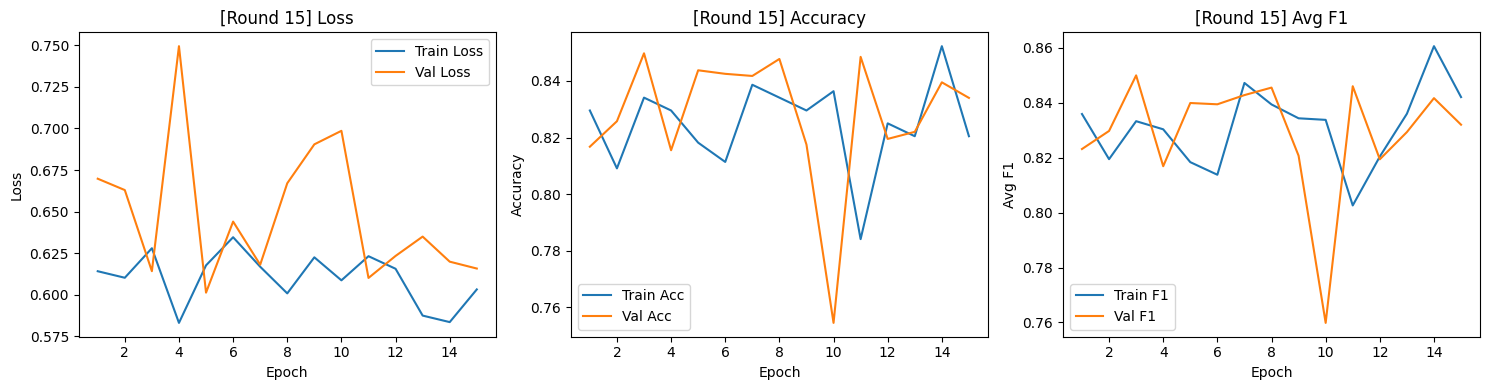


[AL Round 16/20] — Labeled samples: 450



Epoch 15/15
Train — Loss: 0.9337 | Acc: 0.4733 | Avg F1: 0.4531
Val   — Loss: 0.8585 | Acc: 0.5597 | Avg F1: 0.6053


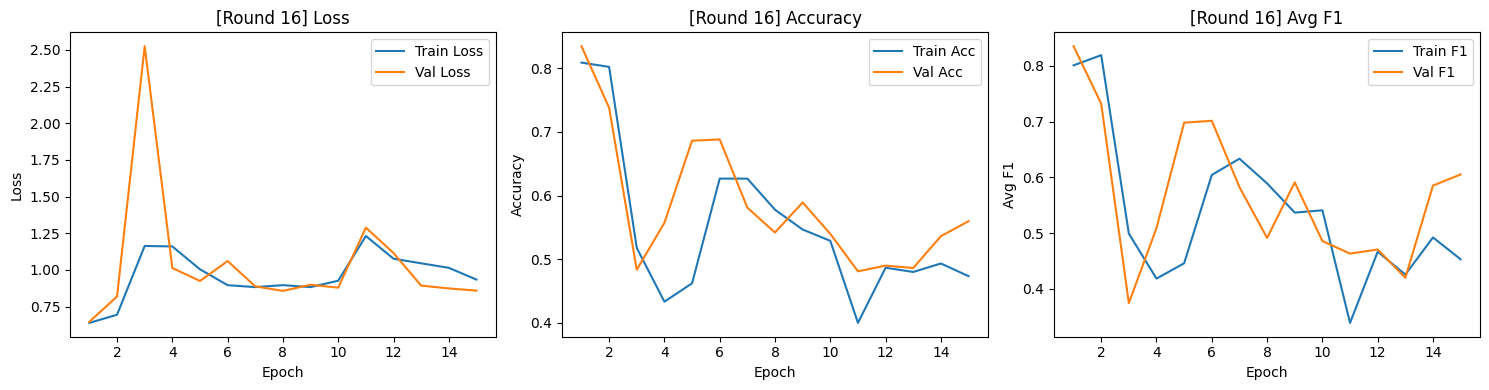


[AL Round 17/20] — Labeled samples: 460



Epoch 15/15
Train — Loss: 0.7933 | Acc: 0.6543 | Avg F1: 0.6877
Val   — Loss: 0.7355 | Acc: 0.7893 | Avg F1: 0.7987


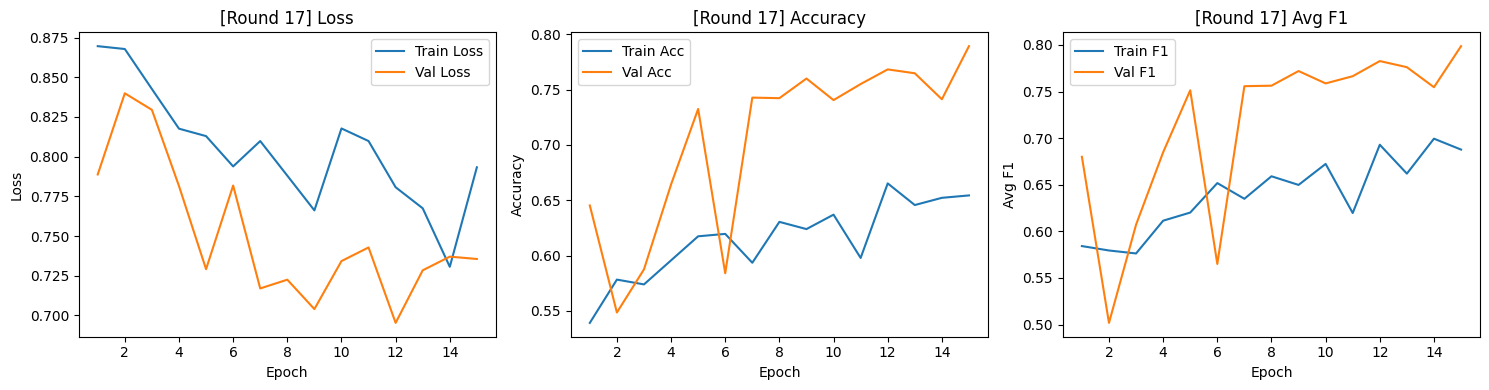


[AL Round 18/20] — Labeled samples: 470



Epoch 15/15
Train — Loss: 0.6976 | Acc: 0.7383 | Avg F1: 0.7595
Val   — Loss: 0.6890 | Acc: 0.8077 | Avg F1: 0.8104


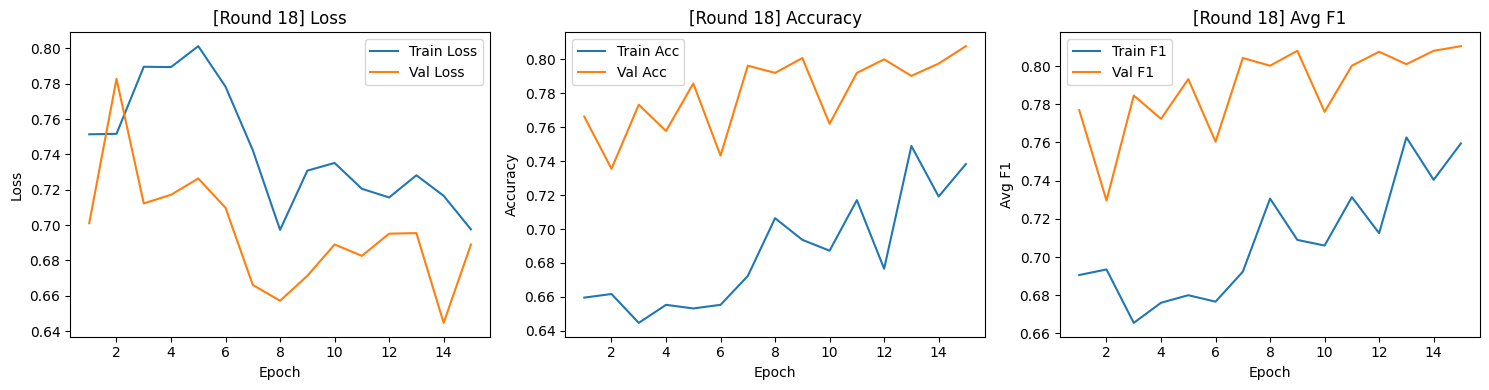


[AL Round 19/20] — Labeled samples: 480



Epoch 15/15
Train — Loss: 0.6948 | Acc: 0.7667 | Avg F1: 0.7842
Val   — Loss: 0.6643 | Acc: 0.8140 | Avg F1: 0.8184


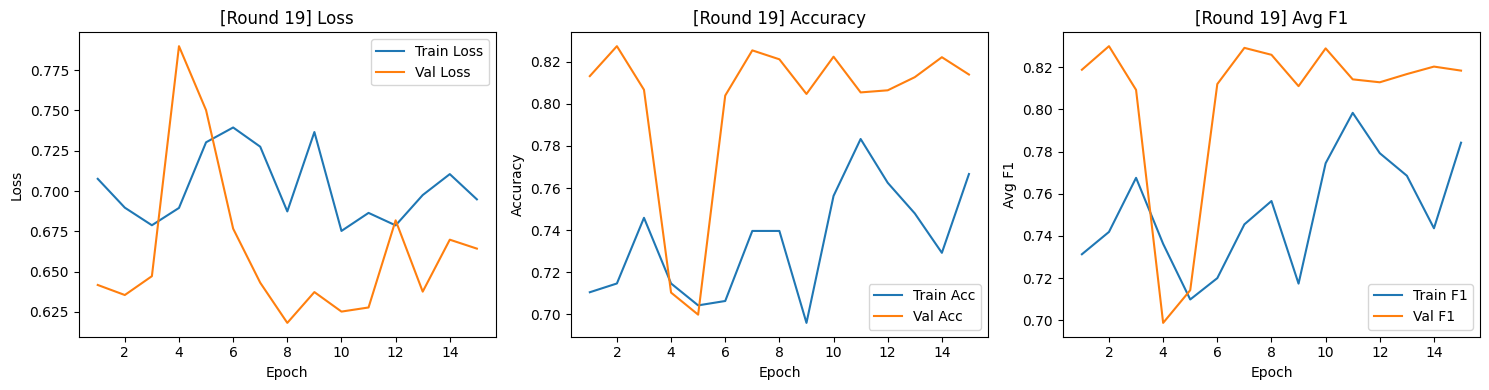


[AL Round 20/20] — Labeled samples: 490



Epoch 15/15
Train — Loss: 0.6503 | Acc: 0.7776 | Avg F1: 0.7931
Val   — Loss: 0.6222 | Acc: 0.8405 | Avg F1: 0.8399


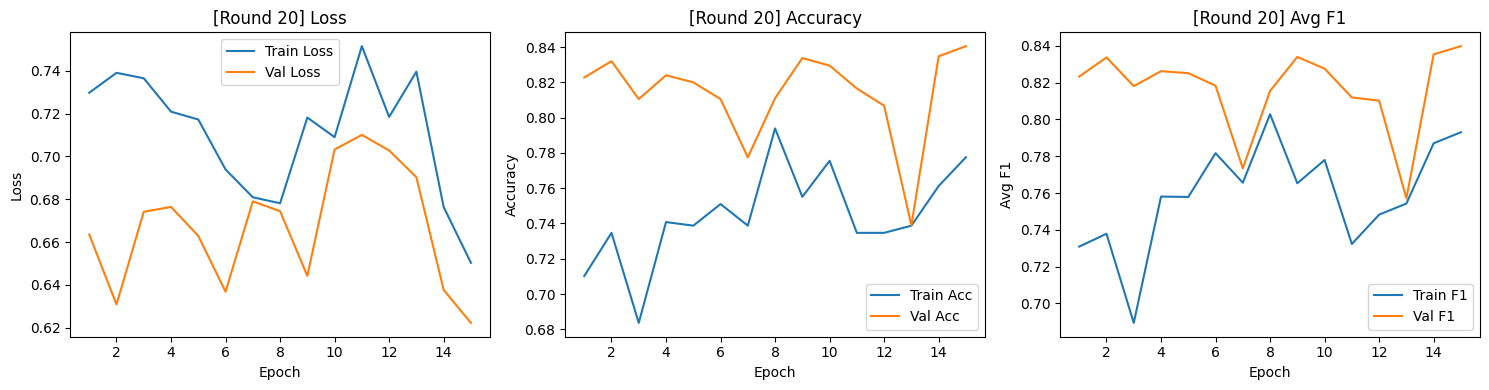

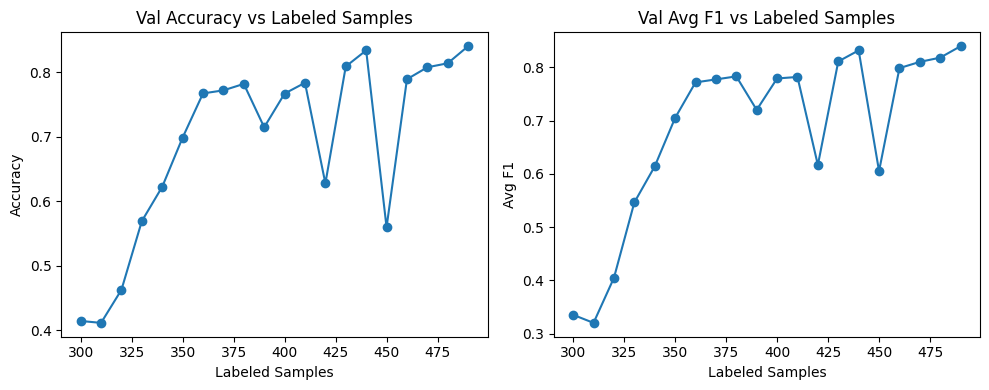


=== Running strategy: LEAST_CONFIDENT ===

[AL Round 1/20] — Labeled samples: 300



Epoch 5/5
Train — Loss: 1.2378 | Acc: 0.3267 | Avg F1: 0.3284
Val   — Loss: 14.6843 | Acc: 0.5010 | Avg F1: 0.3567


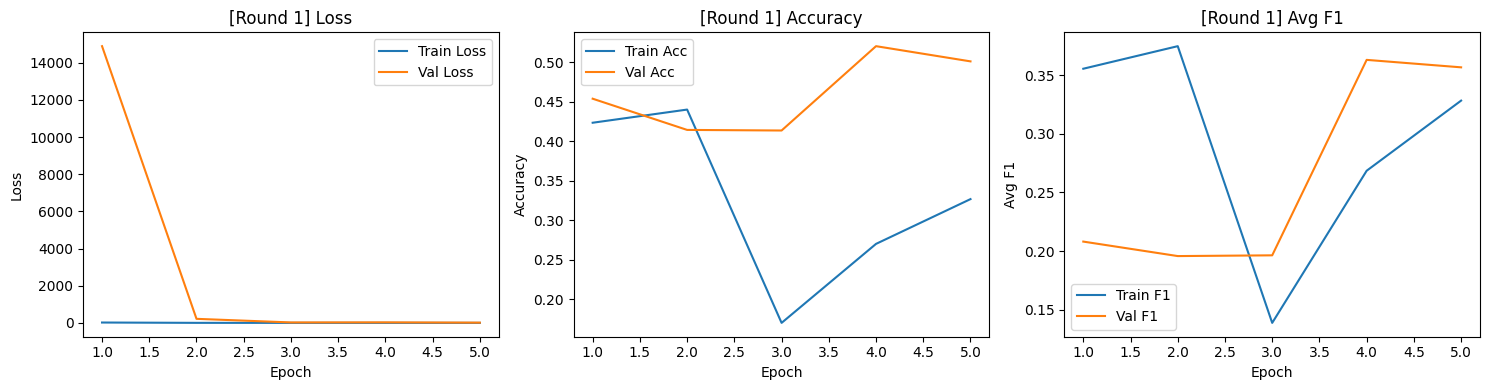


[AL Round 2/20] — Labeled samples: 310



Epoch 5/5
Train — Loss: 1.0787 | Acc: 0.3419 | Avg F1: 0.3323
Val   — Loss: 1.1818 | Acc: 0.3832 | Avg F1: 0.2740


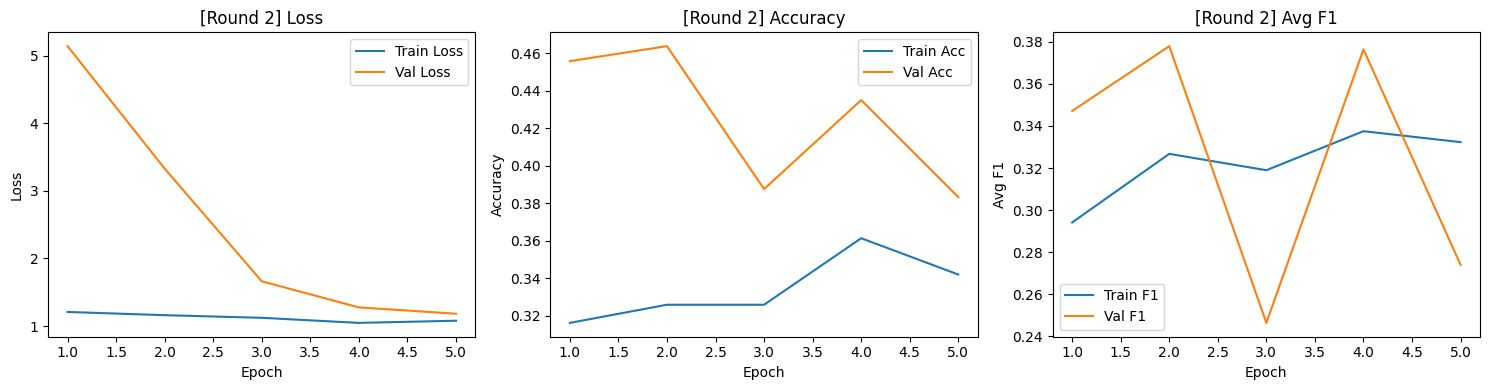


[AL Round 3/20] — Labeled samples: 320



Epoch 5/5
Train — Loss: 0.9754 | Acc: 0.4313 | Avg F1: 0.4189
Val   — Loss: 0.9661 | Acc: 0.4713 | Avg F1: 0.4486


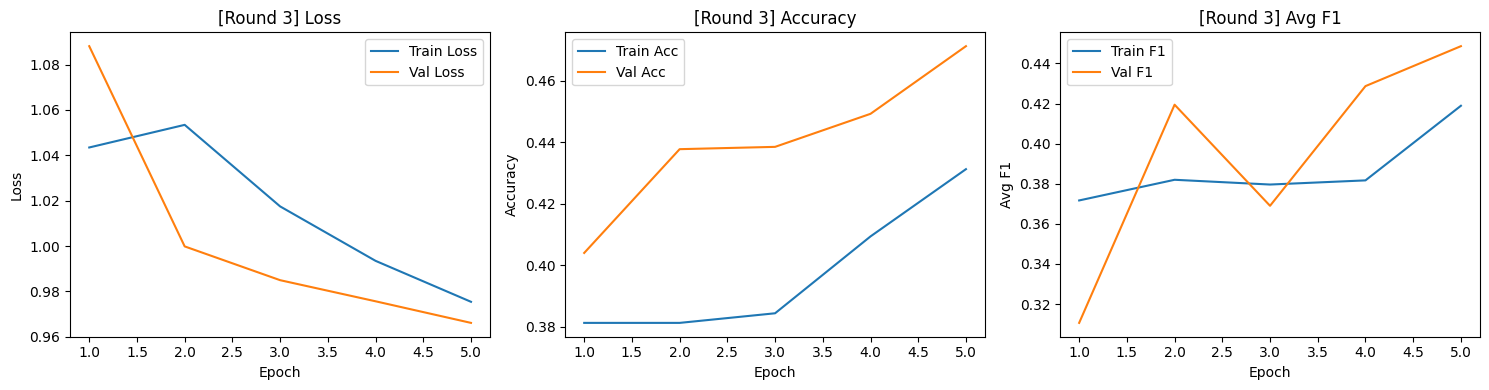


[AL Round 4/20] — Labeled samples: 330



Epoch 5/5
Train — Loss: 0.9522 | Acc: 0.3879 | Avg F1: 0.3705
Val   — Loss: 0.9104 | Acc: 0.4637 | Avg F1: 0.4243


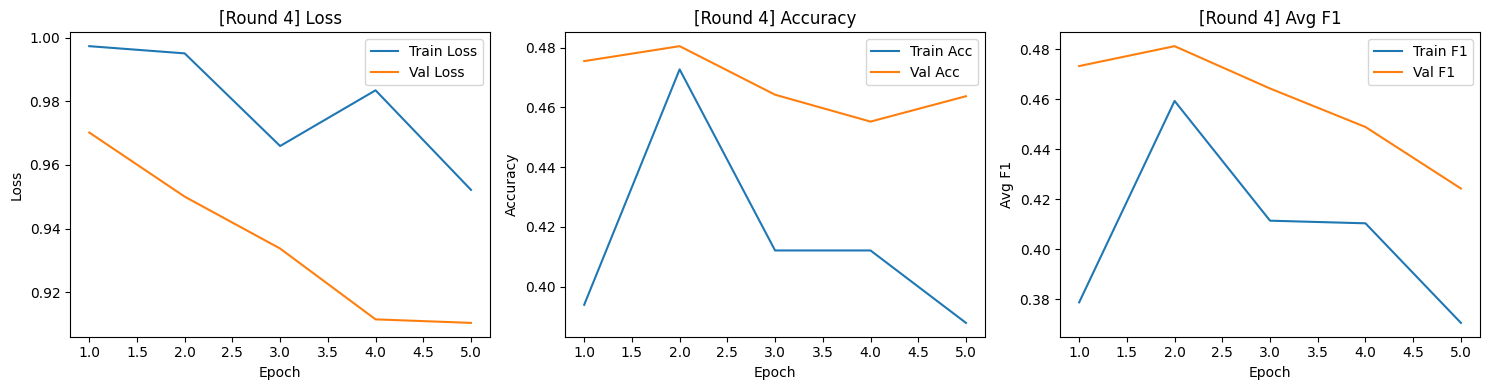


[AL Round 5/20] — Labeled samples: 340



Epoch 10/10
Train — Loss: 0.8113 | Acc: 0.6471 | Avg F1: 0.6530
Val   — Loss: 0.8177 | Acc: 0.6388 | Avg F1: 0.6661


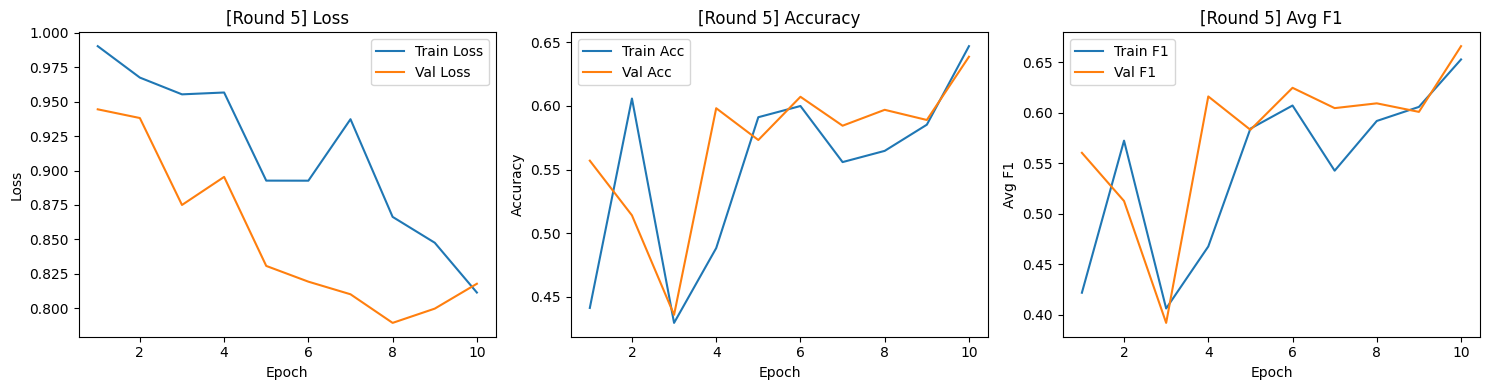


[AL Round 6/20] — Labeled samples: 350



Epoch 10/10
Train — Loss: 0.8504 | Acc: 0.6029 | Avg F1: 0.6132
Val   — Loss: 0.7623 | Acc: 0.6522 | Avg F1: 0.6806


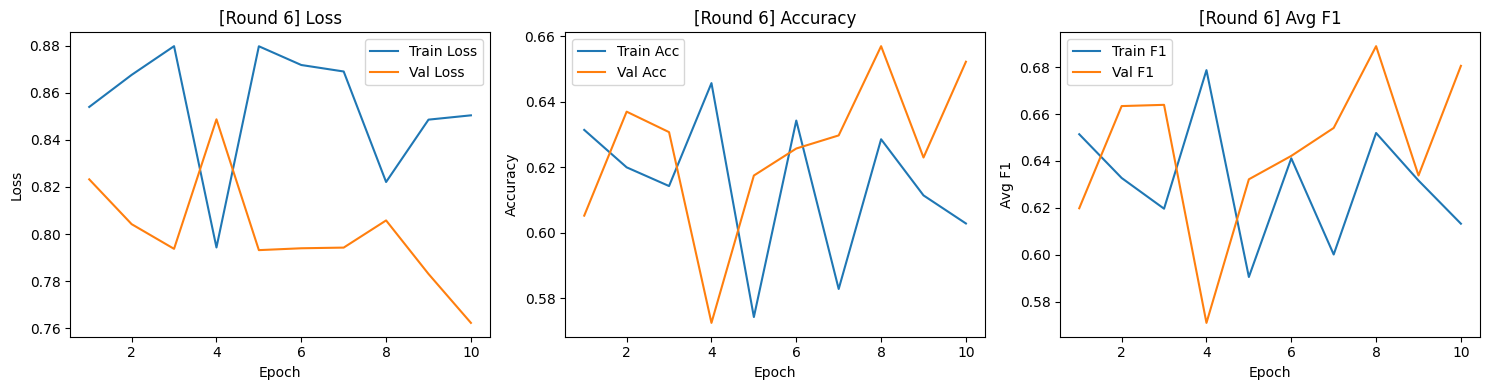


[AL Round 7/20] — Labeled samples: 360



Epoch 10/10
Train — Loss: 0.7992 | Acc: 0.6444 | Avg F1: 0.6655
Val   — Loss: 0.7747 | Acc: 0.6683 | Avg F1: 0.7019


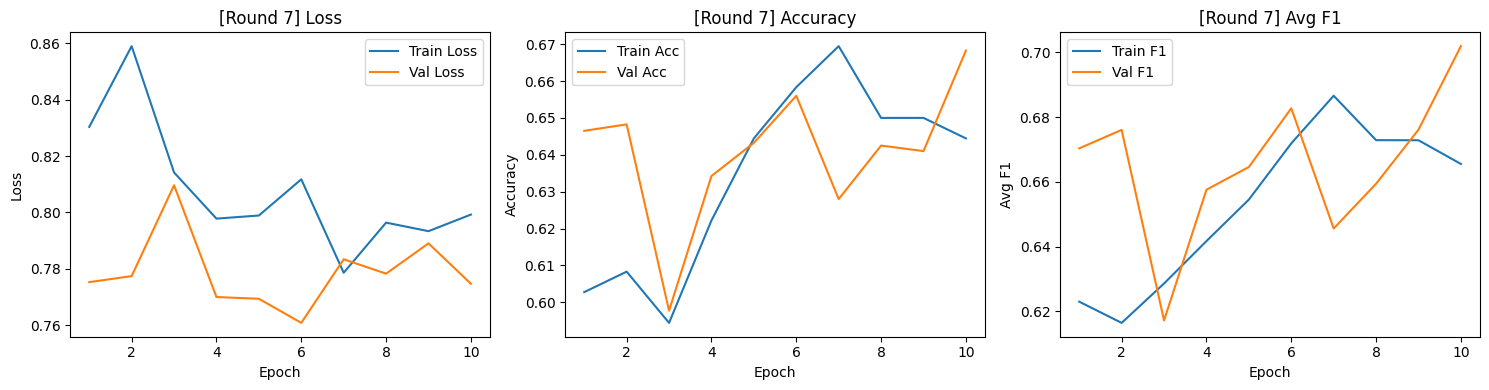


[AL Round 8/20] — Labeled samples: 370



Epoch 10/10
Train — Loss: 0.8326 | Acc: 0.6514 | Avg F1: 0.6762
Val   — Loss: 0.7649 | Acc: 0.6763 | Avg F1: 0.7044


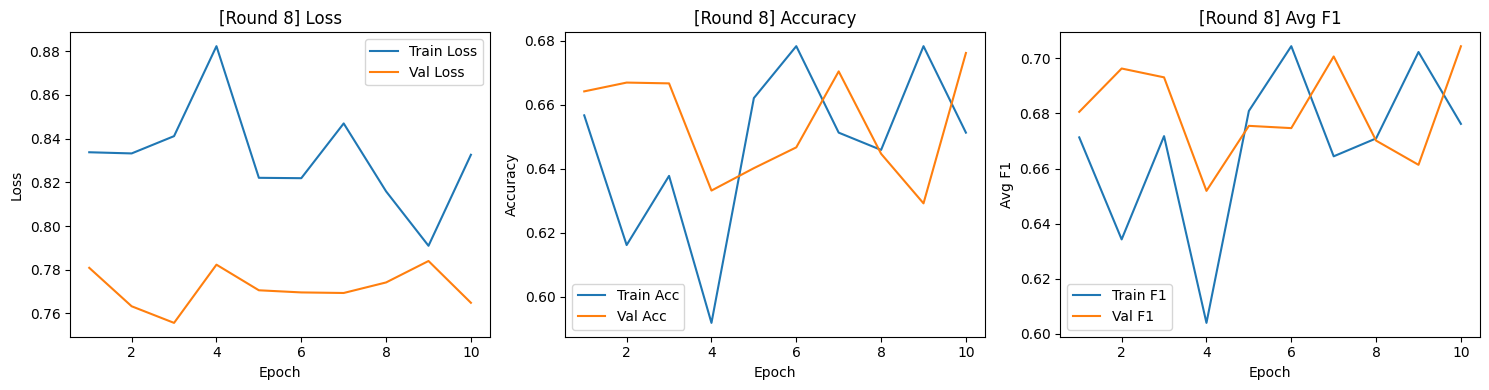


[AL Round 9/20] — Labeled samples: 380



Epoch 10/10
Train — Loss: 0.7824 | Acc: 0.7026 | Avg F1: 0.7211
Val   — Loss: 0.7608 | Acc: 0.6610 | Avg F1: 0.6977


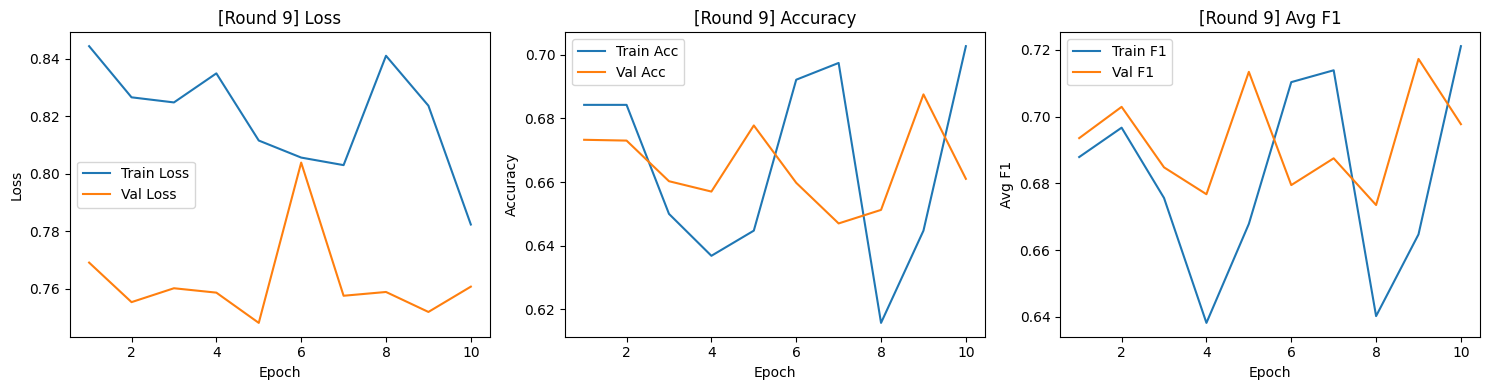


[AL Round 10/20] — Labeled samples: 390



Epoch 10/10
Train — Loss: 0.9820 | Acc: 0.6000 | Avg F1: 0.6053
Val   — Loss: 0.8175 | Acc: 0.6398 | Avg F1: 0.6638


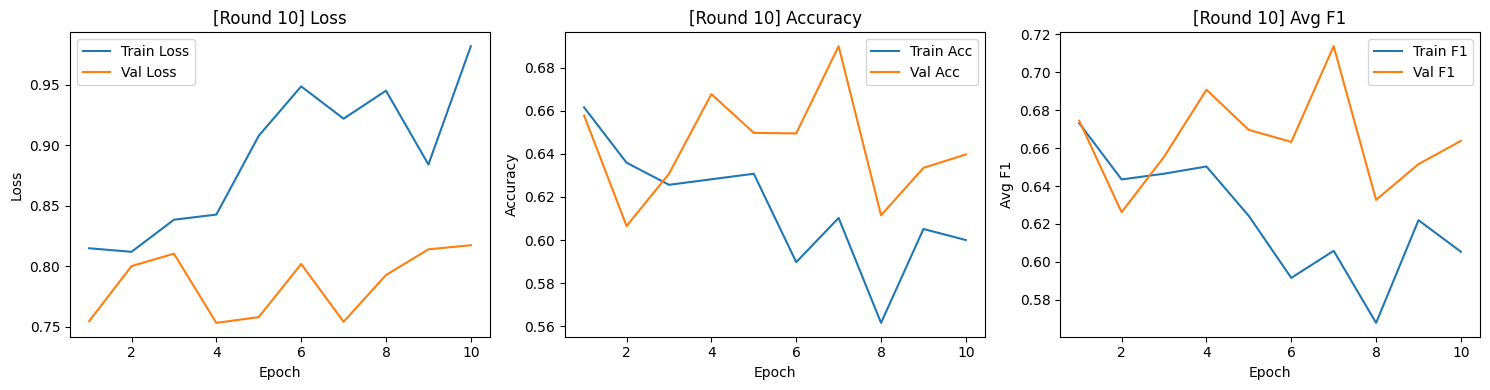


[AL Round 11/20] — Labeled samples: 400



Epoch 10/10
Train — Loss: 0.8125 | Acc: 0.7100 | Avg F1: 0.7244
Val   — Loss: 0.7450 | Acc: 0.7015 | Avg F1: 0.7321


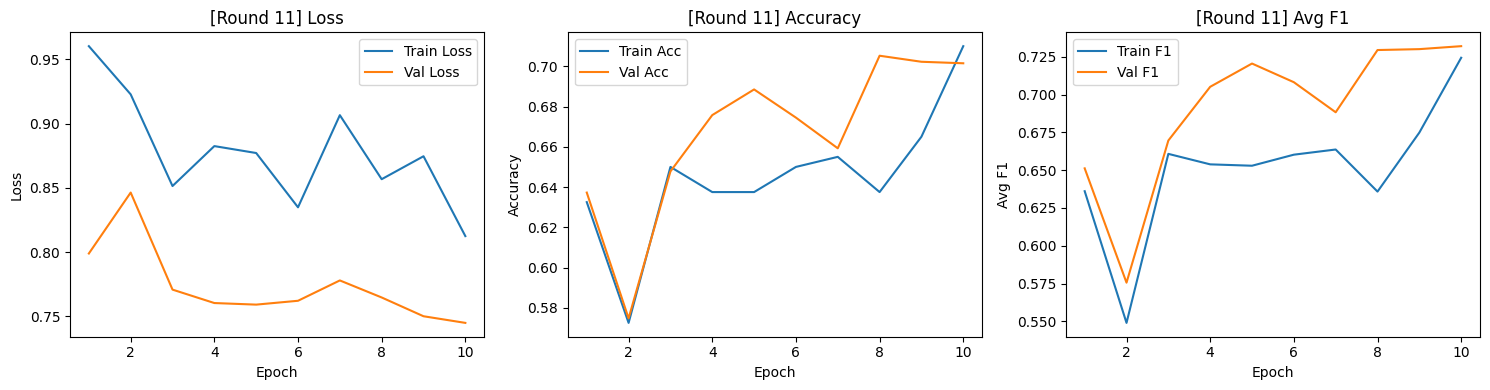


[AL Round 12/20] — Labeled samples: 410



Epoch 15/15
Train — Loss: 0.8191 | Acc: 0.6976 | Avg F1: 0.7039
Val   — Loss: 0.7168 | Acc: 0.7462 | Avg F1: 0.7604


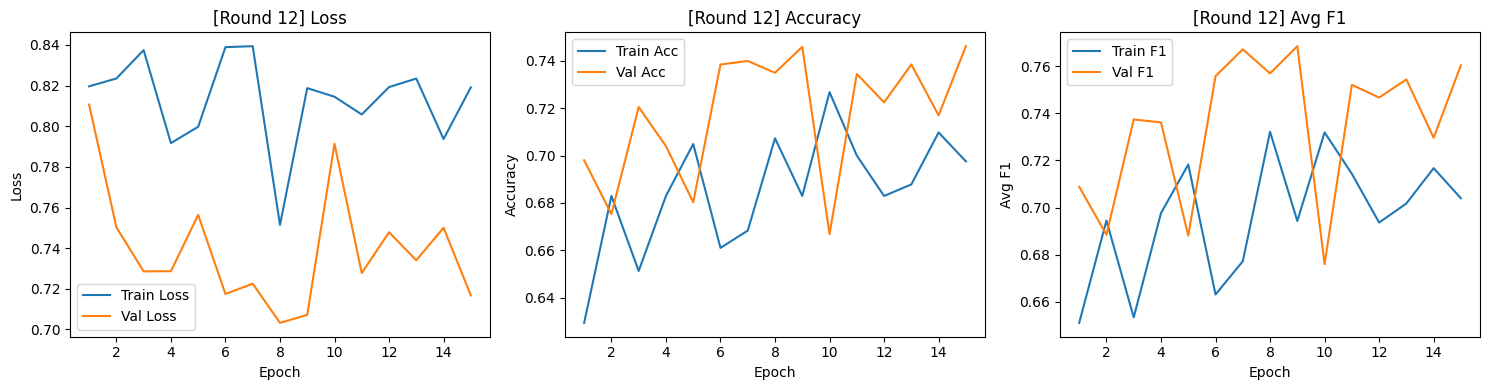


[AL Round 13/20] — Labeled samples: 420



Epoch 15/15
Train — Loss: 0.7789 | Acc: 0.7095 | Avg F1: 0.7106
Val   — Loss: 0.7723 | Acc: 0.6795 | Avg F1: 0.6950


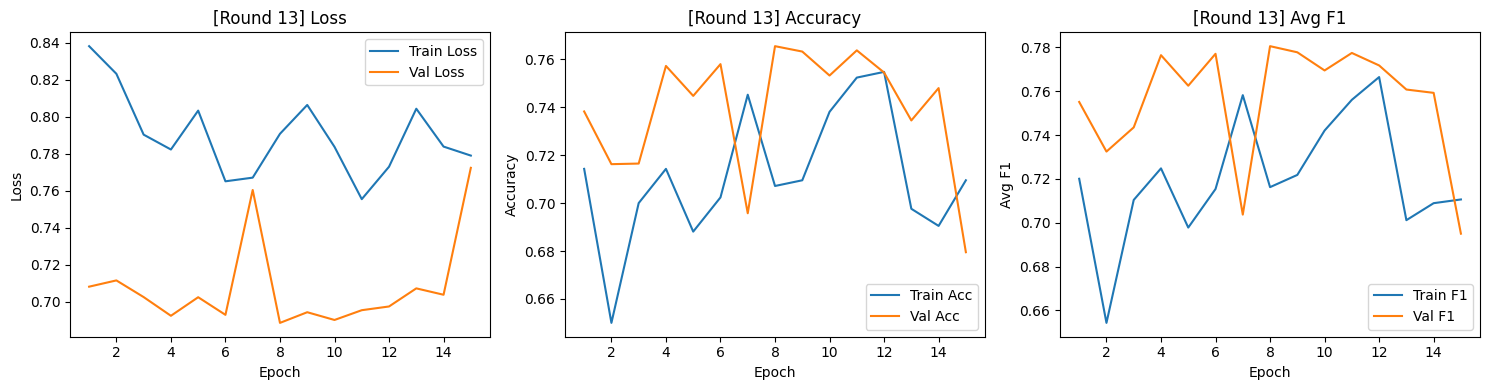


[AL Round 14/20] — Labeled samples: 430



Epoch 15/15
Train — Loss: 0.8313 | Acc: 0.6930 | Avg F1: 0.7031
Val   — Loss: 0.6697 | Acc: 0.7788 | Avg F1: 0.7959


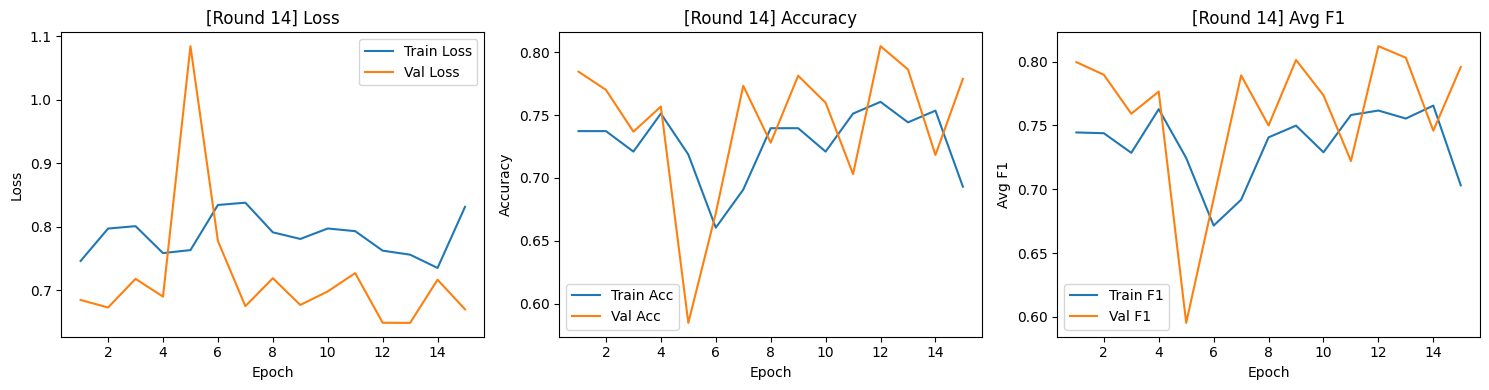


[AL Round 15/20] — Labeled samples: 440



Epoch 15/15
Train — Loss: 0.7149 | Acc: 0.7795 | Avg F1: 0.7935
Val   — Loss: 0.6406 | Acc: 0.8030 | Avg F1: 0.8098


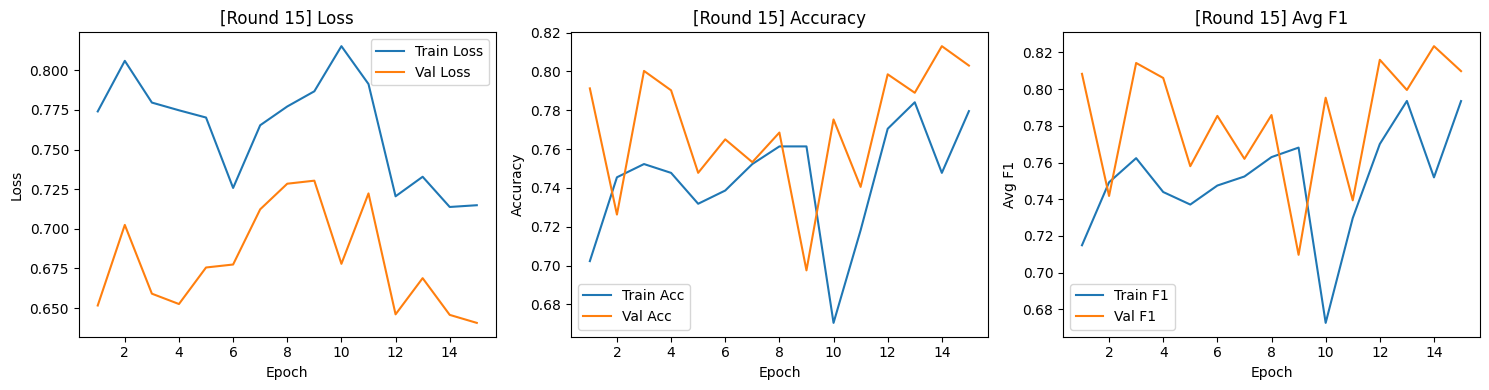


[AL Round 16/20] — Labeled samples: 450



Epoch 15/15
Train — Loss: 0.9821 | Acc: 0.5156 | Avg F1: 0.5314
Val   — Loss: 0.7810 | Acc: 0.6580 | Avg F1: 0.6790


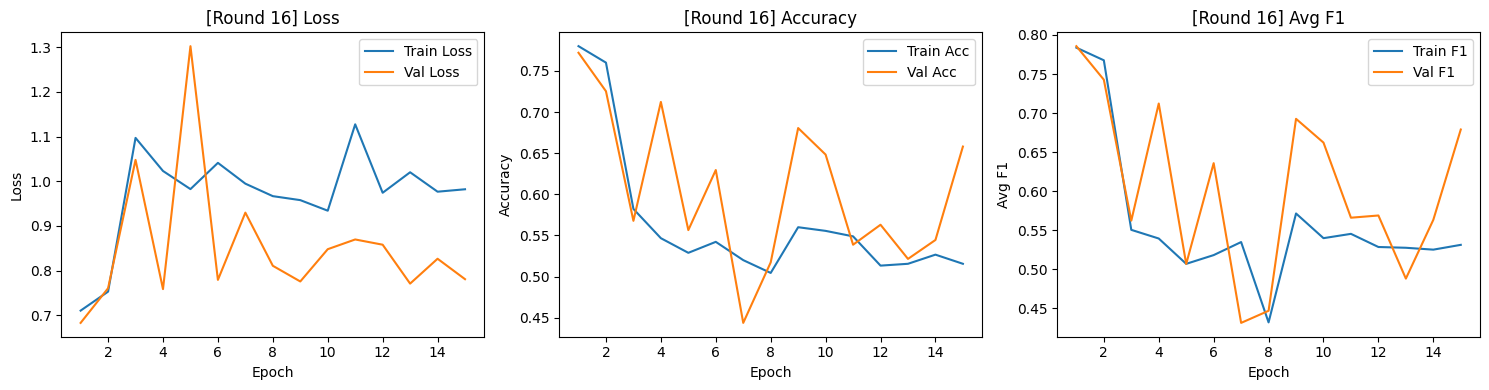


[AL Round 17/20] — Labeled samples: 460



Epoch 15/15
Train — Loss: 0.9277 | Acc: 0.5891 | Avg F1: 0.5996
Val   — Loss: 0.7334 | Acc: 0.7163 | Avg F1: 0.7427


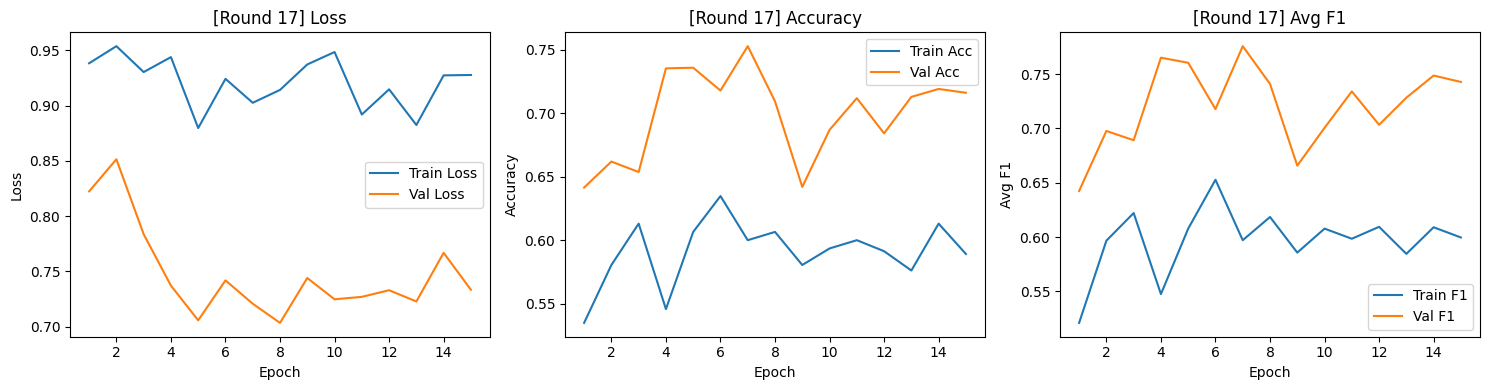


[AL Round 18/20] — Labeled samples: 470



Epoch 15/15
Train — Loss: 0.8160 | Acc: 0.6383 | Avg F1: 0.6473
Val   — Loss: 0.6255 | Acc: 0.8063 | Avg F1: 0.8198


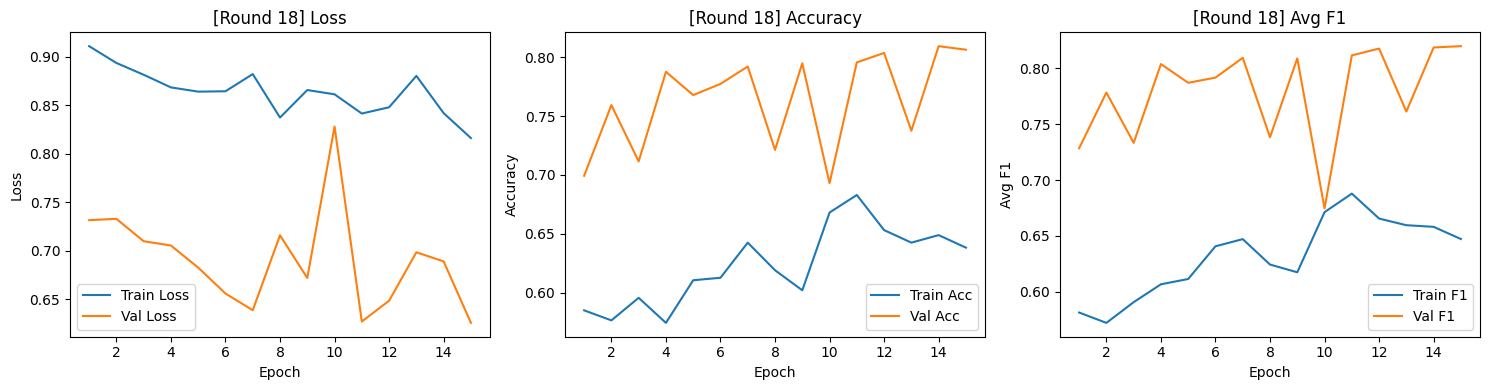


[AL Round 19/20] — Labeled samples: 480



Epoch 15/15
Train — Loss: 0.7929 | Acc: 0.7021 | Avg F1: 0.7073
Val   — Loss: 0.6326 | Acc: 0.8070 | Avg F1: 0.8217


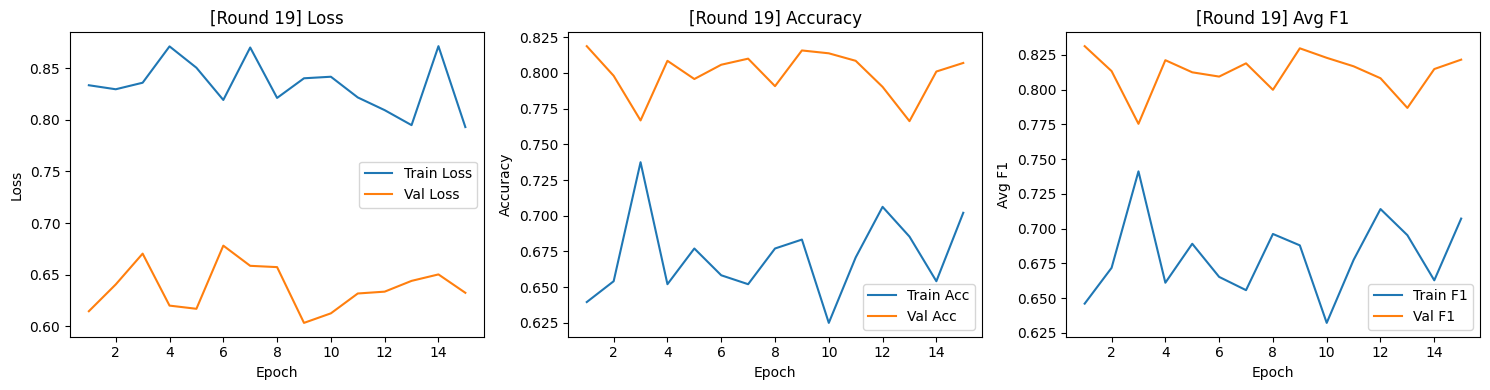


[AL Round 20/20] — Labeled samples: 490



Epoch 15/15
Train — Loss: 0.8261 | Acc: 0.6898 | Avg F1: 0.6967
Val   — Loss: 0.6135 | Acc: 0.8247 | Avg F1: 0.8337


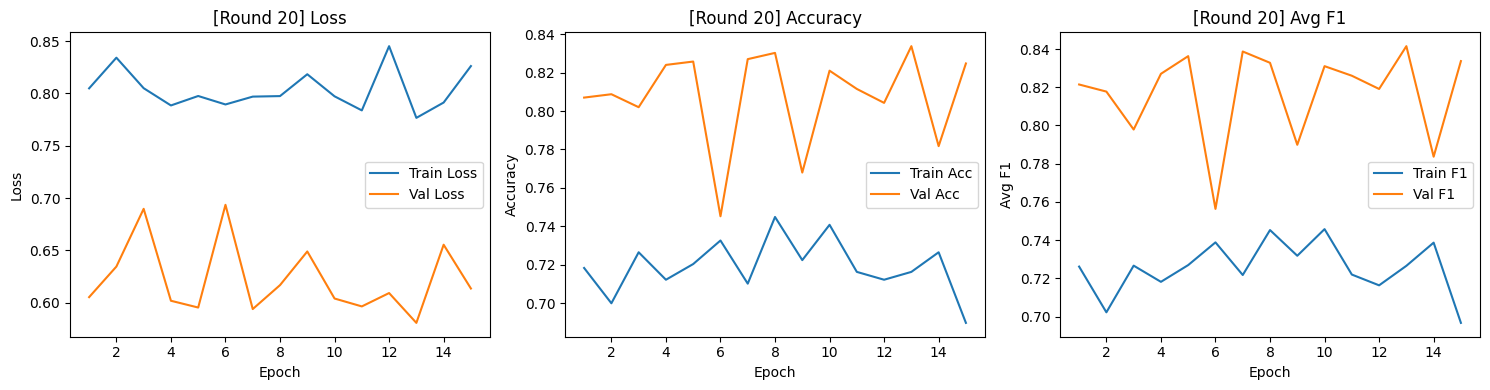

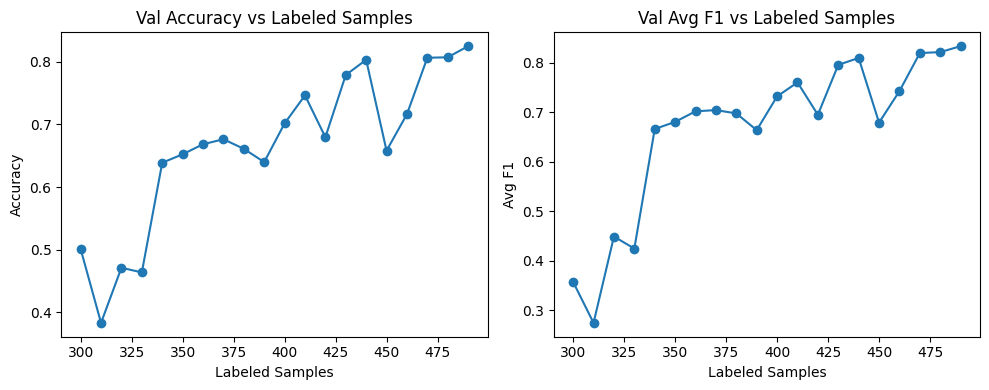

In [16]:
all_histories = {}

for initial_labeled, iters,query_size in data:
    initial_labeled= 1-initial_labeled/len(X_pool)
    X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X_pool, y_pool, test_size=initial_labeled, stratify=y_pool, random_state=42)
    print(f"X_labeled shape: {X_labeled.shape}")
    print(f"y_labeled shape: {y_labeled.shape}")
    print(f"X_unlabeled shape: {X_unlabeled.shape}")
    print(f"y_unlabeled shape: {y_unlabeled.shape}")
    
    
    labeled_dataset = Dataset(X_labeled, y_labeled)
    unlabeled_dataset = Dataset(X_unlabeled, y_unlabeled)
    val_dataset = Dataset(X_val, y_val)
    
    for strat in strategies:
        print(f"\n=== Running strategy: {strat.upper()} ===")
        
        # Reset datasets to initial versions (deepcopy to avoid mutations)
        labeled = copy.deepcopy(labeled_dataset)
        unlabeled = copy.deepcopy(unlabeled_dataset)
    
        model.load_state_dict(copy.deepcopy(initial_state_dict))
        
        hist = active_learning_loop(
            model,
            labeled_dataset=labeled,
            unlabeled_dataset=unlabeled,
            val_dataset=val_dataset,
            strategy=strat,
            device=device,
            iters=iters,
            query_size=query_size,
            final_epochs=15,
            loss_mode=loss_mode
        )
        
        all_histories[(strat, initial_labeled, iters, query_size)] = hist


with open("/kaggle/working/history_entropy.pkl", "wb") as f:
    pickle.dump(all_histories, f)

# Plotting final result

In [17]:
#figuring out different data sizes

def eff_total_labeled_samples(init, iterations, query):
    return round(iterations * init + query * (iterations * (iterations - 1)) // 2)

def total_labeled_samples(init, iterations, query):
    return init+query*iterations

def best_cumsum(available):
    best = (0, 0, 0, 0)  # (cumsum, init, step, n)
    for init in range(1, available + 1):
        for step in range(1, available + 1):
            # max possible n for this init and step
            max_n = (available - init) // step
            for n in range(1, max_n + 1):
                total = init + n * step
                if total <= available:
                    cumsum = n * init + step * n * (n - 1) // 2
                    if cumsum > best[0]:
                        best = (cumsum, init, step, n)
    return best

available = 100
cumsum, init, step, n = best_cumsum(available)
print(f"Max cumsum = {cumsum} with init={init}, step={step}, n={n}")


example = [ (30,20,1), (60,40,1),(120,40,2),(120,80,1),(180,40,3),(300,40,5) ]

for init,iterations,query in example:
    print(f'Init: {init}, Iters: {iterations}, Query: {query}, Total: {total_labeled_samples(init, iterations, query)}, Effective: {eff_total_labeled_samples(init, iterations, query)}')

Max cumsum = 4950 with init=1, step=1, n=99
Init: 30, Iters: 20, Query: 1, Total: 50, Effective: 790
Init: 60, Iters: 40, Query: 1, Total: 100, Effective: 3180
Init: 120, Iters: 40, Query: 2, Total: 200, Effective: 6360
Init: 120, Iters: 80, Query: 1, Total: 200, Effective: 12760
Init: 180, Iters: 40, Query: 3, Total: 300, Effective: 9540
Init: 300, Iters: 40, Query: 5, Total: 500, Effective: 15900


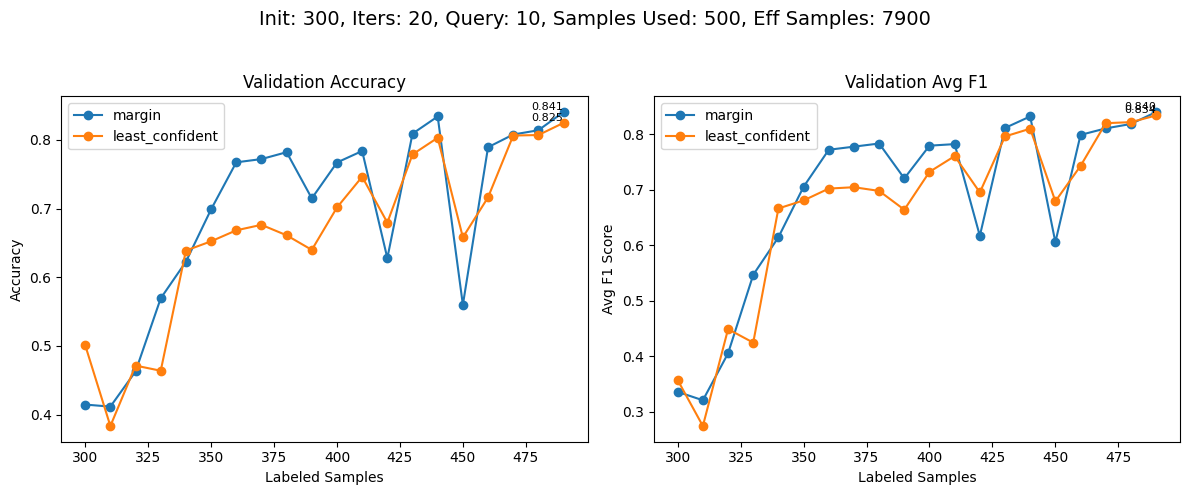

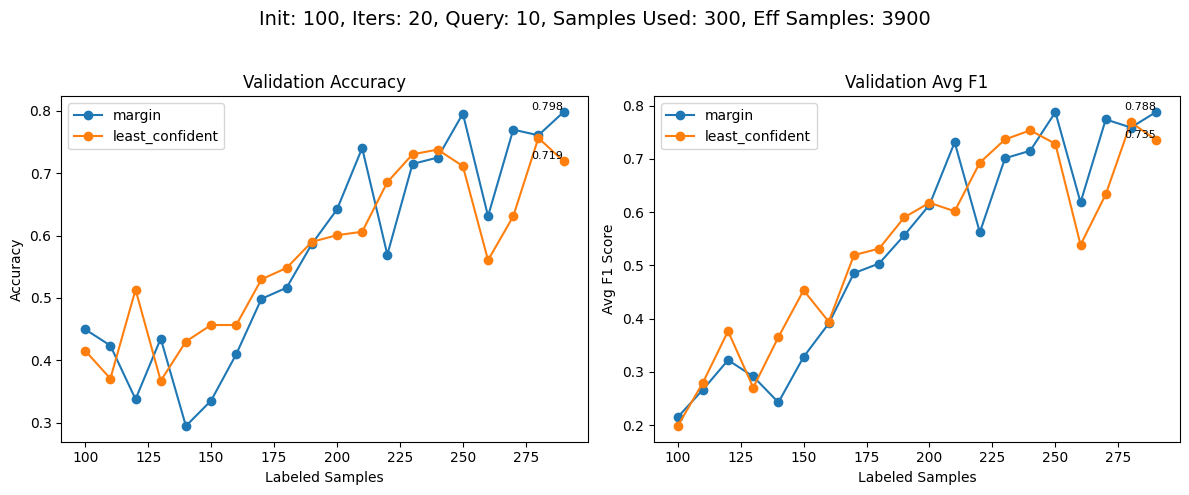

In [18]:
def eff_total_labeled_samples(init, iterations, query):
    return round(iterations * init + query * (iterations * (iterations - 1)) // 2)

def total_labeled_samples(init, iterations, query):
    return init+query*iterations

unique_configs = sorted(set((init_size, iters, query) for (_, init_size, iters, query) in all_histories.keys()))

for init_size, iters, query in unique_configs:
    plt.figure(figsize=(12, 5))
    plt.suptitle(f"Init: {round(len(X_pool)*(1-init_size))}, Iters: {iters}, Query: {query}, Samples Used: {total_labeled_samples(round(len(X_pool)*(1-init_size)), iters, query)}, Eff Samples: {eff_total_labeled_samples(round(len(X_pool)*(1-init_size)), iters, query)}", fontsize=14)
    # Accuracy
    plt.subplot(1, 2, 1)
    for (strat, size, iters_, query_), hist in all_histories.items():
        if (size, iters_, query_) == (init_size, iters, query):
            plt.plot(hist["samples"], hist["round_val_acc"], label=strat, marker='o')
            # Show final accuracy value
            x_final = hist["samples"][-1]
            y_final = hist["round_val_acc"][-1]
            plt.text(x_final, y_final, f"{y_final:.3f}", fontsize=8, ha='right', va='bottom')
    plt.title("Validation Accuracy")
    plt.xlabel("Labeled Samples")
    plt.ylabel("Accuracy")
    plt.legend()

    # F1 Score
    plt.subplot(1, 2, 2)
    for (strat, size, iters_, query_), hist in all_histories.items():
        if (size, iters_, query_) == (init_size, iters, query):
            plt.plot(hist["samples"], hist["round_val_avg_f1"], label=strat, marker='o')
            # Show final F1 value
            x_final = hist["samples"][-1]
            y_final = hist["round_val_avg_f1"][-1]
            plt.text(x_final, y_final, f"{y_final:.3f}", fontsize=8, ha='right', va='bottom')
    plt.title("Validation Avg F1")
    plt.xlabel("Labeled Samples")
    plt.ylabel("Avg F1 Score")
    plt.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [19]:


# Create export directory
export_dir = "active_learning_results"
os.makedirs(export_dir, exist_ok=True)

# Combined CSV file
all_csv_path = os.path.join(export_dir, "all_results.csv")
with open(all_csv_path, mode="w", newline='') as all_csv_file:
    writer_all = csv.writer(all_csv_file)
    writer_all.writerow(["strategy", "init", "iterations", "query", "sample_size", "accuracy", "f1_score"])
    print("strategy,init,iterations,query,sample_size,accuracy,f1_score")  # Header for print

    for init_size, iters, query in unique_configs:
        init_abs = round(len(X_pool) * (1 - init_size))
        filename = f"results_init{init_abs}_iters{iters}_query{query}.csv"
        filepath = os.path.join(export_dir, filename)

        with open(filepath, mode="w", newline='') as f:
            writer = csv.writer(f)
            writer.writerow(["strategy", "init", "iterations", "query", "sample_size", "accuracy", "f1_score"])

            for (strat, size, iters_, query_), hist in all_histories.items():
                if (size, iters_, query_) == (init_size, iters, query):
                    for s, acc, f1 in zip(hist["samples"], hist["round_val_acc"], hist["round_val_avg_f1"]):
                        row = [strat, init_abs, iters, query, s, round(acc, 6), round(f1, 6)]
                        print(",".join(map(str, row)))   # Print CSV-style row
                        writer.writerow(row)
                        writer_all.writerow(row)

print(f"\n✅ All results exported to directory: {export_dir}")


strategy,init,iterations,query,sample_size,accuracy,f1_score
margin,300,20,10,300,0.4145,0.33554
margin,300,20,10,310,0.4115,0.320408
margin,300,20,10,320,0.46275,0.404919
margin,300,20,10,330,0.56925,0.546473
margin,300,20,10,340,0.6225,0.614159
margin,300,20,10,350,0.69875,0.705179
margin,300,20,10,360,0.76725,0.771867
margin,300,20,10,370,0.772,0.777477
margin,300,20,10,380,0.782,0.783148
margin,300,20,10,390,0.71475,0.720255
margin,300,20,10,400,0.767,0.779244
margin,300,20,10,410,0.78375,0.782057
margin,300,20,10,420,0.62775,0.616757
margin,300,20,10,430,0.809,0.81116
margin,300,20,10,440,0.834,0.831953
margin,300,20,10,450,0.55975,0.605274
margin,300,20,10,460,0.78925,0.798663
margin,300,20,10,470,0.80775,0.810384
margin,300,20,10,480,0.814,0.818354
margin,300,20,10,490,0.8405,0.839873
least_confident,300,20,10,300,0.501,0.356741
least_confident,300,20,10,310,0.38325,0.273988
least_confident,300,20,10,320,0.47125,0.448607
least_confident,300,20,10,330,0.46375,0.424282
least_confi